*  DSC530-T302 Data Exploration and Analysis (2261-1)
*  Final Project 
*  Hope Lopez

I am loading the libraries below for use throughout the various tasks for this project.

In [309]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# **Exploring Animal Shelter Outcomes: Statistical Insights & Predictive Modeling with Austin Animal Center Data**


## **Preliminary Preparation Tasks**

### **1. Dataset Selection**

#### 1A. Adequacy Check

I've loaded my dataset as a pandas df, and then ran the .info() function to check dataset size, column count, column names, non-null counts for each column along with the datatype (Dtype) of the values in each column. Note that this dataset contains a total of 7,225 rows and 14 columns. Per the data source description, this dataset covers all animals processed by Austin Animal Center. This makes the dataset representative of Austin Animal Center shelter outcomes from May 2025 to November 18th, 2025 (date of dataset retrieval). A peruse of the available features in this dataset prove the variables are relevant to the analysis I will be performing. Features such as Type (i.e. dog/cat/etc.), Sex (Male/Female), Outcome Status, Primary Breed, Primary Color and Days in Shelter provide a comprehensive view of the animals processed by Austin Animal Center in the given time period. I am confident that I will be able to extract insights through analysis of this dataset thanks to the adequate size (value counts), descriptive features, and integrity of the data source, which I will elaborate on further in 1B. 

In [311]:
# creates a new DF called 'atx_animalshelter_data' to hold the .csv data
atx_animalshelter_data = pd.read_csv('Austin_Animal_Center_Outcomes_20251118.csv')
# generates a quick summary of the df for my reference 
atx_animalshelter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7225 entries, 0 to 7224
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Outcome Date       7225 non-null   object
 1   Animal ID          7225 non-null   int64 
 2   Name               4211 non-null   object
 3   Outcome Status     7225 non-null   object
 4   Euthanasia Reason  479 non-null    object
 5   Type               7225 non-null   object
 6   Sex                7216 non-null   object
 7   Spayed/Neutered    7214 non-null   object
 8   Primary Breed      7225 non-null   object
 9   Primary Color      7225 non-null   object
 10  Secondary Color    3821 non-null   object
 11  Date of Birth      6756 non-null   object
 12  Intake Date        7225 non-null   object
 13  Days in Shelter    7225 non-null   object
dtypes: int64(1), object(13)
memory usage: 790.4+ KB


#### 1B. Data Integrity

The Austin_Animal_Center_Outcomes_20251118.csv was acquired on 11/18/2025 at 7:40PM CT from the City of Austin, Texas via data.austintexas.gov. This is an official government open data source. The provided description on the data.austintexas.gov webpage states: "This dataset records each instance of an animal in the Austin Animal Center's database being updated to an outgoing status, starting from May 5, 2025 (the launch date of our ShelterBuddy system). Data is refreshed hourly." For context, ShelterBuddy is an animal shelter management software that facilitates the tracking of animal shelter activities like intakes, outcomes, licenses, donations and more. When reviewing the dataset, most variables are self-explanatory however, the 'Outcome Status' values were slightly ambiguous for someone not in this field, I was able to source a ShelterBuddy Status List which provides descriptions for each status.(Reid, 2023) This helped me to clarify and interpret the meaning of any given Outcome Status in the Dataset for the Variable Characteristics with Summary Statistics section of this project. 

One potential bias I would like to highlight is that these outcomes reflect local adoption demand in Austin, TX, not universal behavior.

Data Source Link: https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/gsvs-ypi7/about_data

Additional Resources: 

Reid, S. (2023, July 28). Shelter Buddy status list (with definitions). ShelterBuddy Help Guides. https://shelterbuddy.zendesk.com/hc/en-us/articles/360002082995-Shelter-Buddy-Status-List-with-definitions

Banfield Pet Hospital. (n.d.). Dog & cat life stages - Banfield Pet Hospital https://www.banfield.com/Senior-hub/What-to-expect/Life-stages-of-cats-and-dogs

### **2. Data Cleaning & Preperation**

#### 2A. Handle Missing Values or Outliers

**Handling Missing Values**

To handle missing values I first ran a null count on the original DataFrame and inspected common placeholder strings (e.g., "Unknown", "Unspecified"). The dataset contained 7,225 rows initially. Key findings and actions are summarized below:
- Euthanasia Reason had the highest null count (6,746). This field is only populated when an animal was euthanized, so nulls are expected and are treated as missing (pd.NA) for analysis.
- Secondary Color had 3,404 nulls (~47% of rows). Secondary color is often not applicable. I kept the column for EDA richness but excluded it from modeling because of high missingness.
- Name had 3,014 nulls. I standardized missing/generic name values to pd.NA and replaced a list of identified generic names (e.g., "Unknown", "Kitten", "Puppy", "Animal Test", etc.) with pd.NA. One record with a Name value "Test Record Only" was dropped because it clearly reflected a non‑real case (Days in Shelter = 0 and DOB missing). After dropping that test record the dataset length decreased by one (from 7,225 to 7,224).
- Small null counts in Sex (9) and Spayed/Neutered (11) columns were treaded as 'Unknown'. After this update, I counted the number of 'Unknown' values in these 2 columns and found a staggeringly large count 982 for Sex and 1,169 in Spayed/Neutered. Meaning there were originally nearly 1,000 unknown/Unknown values in each of these 2 columns originally. For consistency I am collapsing both nulls and unknown/Unknown values into pd.Na. 
- I found a small number of placeholder values in Primary Color (5) and Primary Breed (9) such as "unknown", "Unspecified", and "Unknown - DISPATCH ONLY". I converted these to pd.NA for consistency across categorical features.
- Date of Birth had 469 missing values (~6.5%). Because age is critical to my analyses, I created a DOB‑cleaned DataFrame 'nonna_dob' by dropping rows with missing DOBs. This preserves the original DataFrame while providing a cleaned copy for age‑dependent EDA and modeling. After dropping the null DOB rows, nonna_dob contains 6,756 rows.
  
**Handling Outliers**
- Many columns were object dtype after import. For the nonna_dob df, I converted Date of Birth, Intake Date, and Outcome Date to datetime. I cleaned Days in Shelter by stripping commas and converting it to integer.
- From the boxplot, Days in Shelter is highly right‑skewed with a long tail of long‑stay animals. I inspected extreme values and counted records with Days in Shelter > 500 (21 records; ~0.31% of nonna_dob) and >1000 (4 records; ~0.06% of nonna_dob). These are real, valid cases rather than data entry errors, so I retained them in the dataset. For the later modeling tasks I use transformations and capping, later in this project I capped Days in Shelter at the 99th percentile, then applied log1p to create Log_days_in_shelter; age variables were square‑root transformed. I also perform sensitivity checks (compare results with/without capping or outliers) and use robust visualizations when presenting distributions.

**Notes on reproducibility and transparency**
- I preserved the original DataFrame (atx_animalshelter_data) and created nonna_dob for DOB‑dependent work so all cleaning steps are reversible and auditable.
- I report row counts after each major cleaning step (original → drop test record → drop DOB nulls → drop rows with missing predictors for modeling) in the notebook to make it clear how many records were used at each stage.

In [43]:
# checks missing values by column
atx_animalshelter_data.isnull().sum()

Outcome Date            0
Animal ID               0
Name                 3014
Outcome Status          0
Euthanasia Reason    6746
Type                    0
Sex                     9
Spayed/Neutered        11
Primary Breed           0
Primary Color           0
Secondary Color      3404
Date of Birth         469
Intake Date             0
Days in Shelter         0
dtype: int64

In [44]:
# defines list of 'generic' names 
generic_names = [
    'Unknown' , 'Unknonwn' , 'No Name' , 'Animal Test Ra 1' , 'Animal Test RA 2' , 
    'Puppy 1' , 'Puppy 2' , 'Kitten' , 'Kitten 1' , 'Kitten 2' , 'Kitten 3' , 'Kitty' , 'Kitty 1' , 
    'Kitty 2' , 'Kitty 3' , 'Ogliddidoggliddodog 19','Otemotesnoterdam 19', '(582)' , '(581)' , '(580)' , 
    '(576)' , '(575)', '(573)', '(572)', '21']

# counts occurances of each generic name in the dataset
for name in generic_names:
    count = (atx_animalshelter_data['Name'] == name).sum()
    # display results
    print(f"{name}: {count}")

# counts occurances of 'Test Record Only' value in Name col. 
print((atx_animalshelter_data['Name'] == 'Test Record Only').sum())

Unknown: 82
Unknonwn: 2
No Name: 5
Animal Test Ra 1: 1
Animal Test RA 2: 1
Puppy 1: 1
Puppy 2: 1
Kitten: 2
Kitten 1: 2
Kitten 2: 1
Kitten 3: 1
Kitty: 3
Kitty 1: 1
Kitty 2: 1
Kitty 3: 1
Ogliddidoggliddodog 19: 1
Otemotesnoterdam 19: 1
(582): 1
(581): 1
(580): 1
(576): 1
(575): 1
(573): 1
(572): 1
21: 1
1


In [57]:
# replaces 'generic' names with NA
atx_animalshelter_data['Name'] = (
    atx_animalshelter_data['Name']
    .replace(generic_names, pd.NA)
    # standardizes all missing values to pd.NA
    .fillna(pd.NA))

In [85]:
# drops test record from the dataset
atx_animalshelter_data = atx_animalshelter_data[atx_animalshelter_data['Name']!= 'Test Record Only']

# quick check to validate the test record was succesfully dropped
print((atx_animalshelter_data['Name'] == 'Test Record Only').sum())

0


In [56]:
print("True nulls in Sex:", atx_animalshelter_data['Sex'].isna().sum())
print("String 'Unknown' in Sex:", (atx_animalshelter_data['Sex'] == 'Unknown').sum())

print("True nulls in Spayed/Neutered:", atx_animalshelter_data['Spayed/Neutered'].isna().sum())
print("String 'Unknown' in Spayed/Neutered:", (atx_animalshelter_data['Spayed/Neutered'] == 'Unknown').sum())

True nulls in Sex: 9
String 'Unknown' in Sex: 973
True nulls in Spayed/Neutered: 11
String 'Unknown' in Spayed/Neutered: 1158


In [208]:
# standardizes Sex col. 
atx_animalshelter_data['Sex'] = (
    atx_animalshelter_data['Sex']
    .replace('Unknown', pd.NA)
    .fillna(pd.NA))
# quick check to validate standardization was successful
print("Missing Sex Count:", atx_animalshelter_data['Sex'].isna().sum())

# standardizes Spayed/Neutered col. 
atx_animalshelter_data['Spayed/Neutered'] = (
    atx_animalshelter_data['Spayed/Neutered']
    .replace('Unknown', pd.NA)
    .fillna(pd.NA))
# quick check to validate standardization was successful
print("Missing Spayed/Neutered Count:", atx_animalshelter_data['Spayed/Neutered'].isna().sum())

# normalize case for spayed/neutered
atx_animalshelter_data['Spayed/Neutered'] = atx_animalshelter_data['Spayed/Neutered'].str.strip().str.title()  # 'Yes', 'No', 'Unknown'

Missing Sex Count: 982
Missing Spayed/Neutered Count: 1169


In [209]:
# standardizes Primary Breed col. 
atx_animalshelter_data['Primary Color'] = (
    atx_animalshelter_data['Primary Color']
    .replace('unknown', pd.NA) )
# quick check to validate standardization was successful
print("Missing Primary Color count:", atx_animalshelter_data['Primary Color'].isna().sum())

# standardizes Primary Breed col. 
atx_animalshelter_data['Primary Breed'] = (
    atx_animalshelter_data['Primary Breed']
    .replace(['Unspecified', 'Unknown - DISPATCH ONLY'], pd.NA))
# quick check to validate standardization was successful
print("Missing Primary Breed count:", atx_animalshelter_data['Primary Breed'].isna().sum())

Missing Primary Color count: 5
Missing Primary Breed count: 9


In [210]:
# creates a new df 'nonnado_dob' with DOB nulls dropped
nonna_dob = atx_animalshelter_data.dropna(subset=['Date of Birth']).copy() # copy method to supress warnings later

# quick check comparing length of initial df and new df
print("Original dataset:", len(atx_animalshelter_data))
print("DOB-cleaned dataset:", len(nonna_dob))
# quick check to validate no na values exist in DOB col. of new df
print("Missing DOBs in new df:", nonna_dob['Date of Birth'].isna().sum())

nonna_dob.info()

Original dataset: 7224
DOB-cleaned dataset: 6756
Missing DOBs in new df: 0
<class 'pandas.core.frame.DataFrame'>
Index: 6756 entries, 0 to 7224
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Outcome Date       6756 non-null   object
 1   Animal ID          6756 non-null   int64 
 2   Name               4011 non-null   object
 3   Outcome Status     6756 non-null   object
 4   Euthanasia Reason  344 non-null    object
 5   Type               6756 non-null   object
 6   Sex                6135 non-null   object
 7   Spayed/Neutered    5983 non-null   object
 8   Primary Breed      6748 non-null   object
 9   Primary Color      6753 non-null   object
 10  Secondary Color    3584 non-null   object
 11  Date of Birth      6756 non-null   object
 12  Intake Date        6756 non-null   object
 13  Days in Shelter    6756 non-null   object
dtypes: int64(1), object(13)
memory usage: 791.7+ KB


In [211]:
# defines the cols. with date values to be converted to datetime
date_cols = ['Date of Birth' , 'Intake Date' , 'Outcome Date']

# converts date cols. to datetime
for col in date_cols:
    nonna_dob[col] = pd.to_datetime(nonna_dob[col], errors = 'coerce')

# quick check to validate the cols are now datetime
print(nonna_dob[date_cols].dtypes)

C:\Users\lahop\AppData\Local\Temp\ipykernel_11980\23326126.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nonna_dob[col] = pd.to_datetime(nonna_dob[col], errors = 'coerce')
C:\Users\lahop\AppData\Local\Temp\ipykernel_11980\23326126.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nonna_dob[col] = pd.to_datetime(nonna_dob[col], errors = 'coerce')


Date of Birth    datetime64[ns]
Intake Date      datetime64[ns]
Outcome Date     datetime64[ns]
dtype: object


In [212]:
# converts Days in Shelter col. to integer dtype
nonna_dob['Days in Shelter'] = (
    nonna_dob['Days in Shelter']
    .str.replace(',', '', regex = True) # strips commas
    .astype(int)) # converts to integer
    
# quick check to validate dtype conversion successful 
print(nonna_dob['Days in Shelter'].dtype)

int32


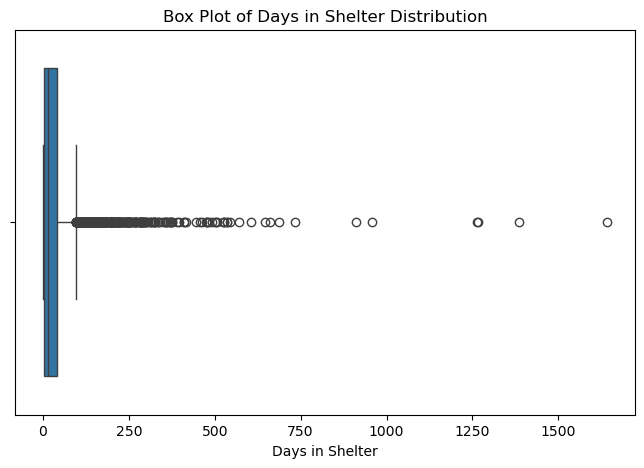

In [213]:
# creates histogram of Days in Shelter to aid visual identification of outliers
plt.figure(figsize = (8, 5)),
sns.boxplot(x = nonna_dob['Days in Shelter']),
plt.title("Box Plot of Days in Shelter Distribution"),
plt.xlabel("Days in Shelter")
plt.show()

In [214]:
# Days in Shelter outlier (>500) count
count_over_500 = (nonna_dob['Days in Shelter'] > 500).sum()
print(count_over_500)
# calculates ct of outliers >500 as a % of 100
percent_over500 = (count_over_500 / 6756) * 100
# displays formatted percentage
print(f"% of animals with shelter stays > 500 days: {percent_over500:.6f}%")

# Days in Shelter outlier (>1000) count
count_over_1000 = (nonna_dob['Days in Shelter'] > 1000).sum()
print(count_over_1000)
# calculates ct of outliers >1000 as a % of 100
percent_over1000 = (count_over_1000 / 6756)
print(f"% of animals with shelter stays > 1000 days: {percent_over1000:.6f}%")

21
% of animals with shelter stays > 500 days: 0.310835%
4
% of animals with shelter stays > 1000 days: 0.000592%


#### 2B. Recoding or Encoding of Variables

I noticed that the 'Type' column had some values like 'kitten' and 'puppy' indicating a juvenile cat/dog. I wanted to keep this column as clean and straightforward as possible, so I cleaned these values, replacing them with 'Cat' or 'Dog' respectively so I could get accurate total counts of each species type in the dataset. Additionally there are 142 animals in the nonna_dob dataset which are not cats or dogs and represent a wide array of animal species (each with relatively low counts), some of which are a bit misleading like 'mammal' which based on the PrimaryBreed values encompasses bats, raccoons, skunks and more. Obviously cats, dogs, rabbits, etc are all mammals so this label is confusing. And 'bird' 'bird(wildlife)' and 'fowl' which have overlaps in the species represented (like chicken which appears under both bird and fowl Types). For clarity of interpretation, and because later tasks like regression, classification, and clustering will rely heavily on large, consistent categories,  I am labeling all non/cat dog animal types as 'Other'. This preserves all records while ensuring the 'Type' variable remains clean and interpretable for downstream analysis. Where relevant, I will conduct sensitivity checks to confirm that the inclusion of ‘Other’ does not distort results in regression, classification, or clustering models.

The Primary Color column is nice because it has no null values, all the info is there. I checked the unique values in this column and found over 80 different primary colors present in the dataset. I decided to create a new column, 'Color_grouped' which maps those 80+ colors into 8 family colors Multi-color, Brown, Black, Orange/Red, Blue, White, Cream/Tan, Grey and Other. These color families are more interpretable and balanced than the original 'Primary Color'. After this mapping, I displayed the counts for each Color_grouped family, Multi-color is the highest at 4108 which is expected because of the initial .info() on the df revealing 3821 non-null Secondary color observations which are all classified as multi-color. Yellow was a special case for mapping because in the dataset I observed it was used exclusively for Labrador Retrievers (from Primary Breed) and non-cat/dog Other type animals. Because yellow labs appear gold/tan in color, I've mapped 'yellow' to Cream/Tan if the type is dog. 

The Date of Birth column gives me insight into the pet's age so I've added 2 additional columns based off of this column, Age_at_intake_y and Age_at_outcome_y which provide the age (in years) of the animal at intake and outcome dates respectively. From age_at_intake_y, I created a new column, Life_stage_at_intake which maps cat or dog ages at intake to a life stage classification (juvenile, young adult, mature adult, senior) based on Banfield Pet Hospital's Dog & cat life stages (Banfield Pet Hospital. (n.d.). I added the life stage column to better understand outcomes for these life stage groups. 

In [215]:
# replaces 'kitten'/'puppy' with cat/dog for consistency & accuracy of type counts
nonna_dob['Type'] = nonna_dob['Type'].replace({
    'Kitten': 'Cat',
    'Puppy': 'Dog'})

# replaces non-cat/dog Types as 'Other'
nonna_dob['Type'] = nonna_dob['Type'].apply(
    lambda x: x if x in ['Cat', 'Dog']
    else 'Other')

# validate replacements
print(nonna_dob['Type'].value_counts())

Type
Cat      4029
Dog      2585
Other     142
Name: count, dtype: int64


In [216]:
# displays all unique Primary Color values
print(nonna_dob['Primary Color'].unique())

# displays the counts for the Primary Color values
print(nonna_dob['Primary Color'].value_counts())

['Chocolate' 'Rust' 'Brown Tabby' 'Blue' 'Black' 'Grey Tabby' 'Torbie'
 'Orange Tabby' 'Red Brown' 'Brown' 'Tri Color' 'White' 'Tortoiseshell'
 'Grey' 'Silver Tabby' 'BLUE TABBY' 'Blue Point' 'Cream' 'Orange Tiger'
 'Tan' 'Calico' 'Wheaten' 'Cream Ginger Tabby' 'Muted Tortoiseshell'
 'Brown Brindle' 'Blue Merle' 'Black Brown' 'Red Merle'
 'Black Tortoiseshell' 'Brindle' 'Red' 'Buff' 'Flame Point' 'Lilac Point'
 'Green' 'Fawn' 'Tabby' 'Apricot' 'Black Brindle' 'LYNX PT' 'Chestnut'
 'Blue Ticked' 'Seal Point' 'Torti Point' 'Blue Brindle' 'Smoke Tabby'
 'Orange' 'Gold' 'Yellow' 'Patch Tabby' 'Sable' 'Blonde'
 'Blue Cream Calico' 'Brown Ticked' 'Blue Cream Tortoiseshell' 'Smoke'
 'Silver Patch Tabby' 'Silver Fawn' 'Bronze' 'Silver Tortoiseshell'
 'Swiss Tri Color' 'Ticked' 'Silver' 'Smoke Tortoiseshell' 'Muted Calico'
 'Ginger Tabby' 'Snow Tabby' 'Cinnamon' 'Buff Tiger' 'Tabby Point'
 'Chocolate Calico' <NA> 'BLUE TIGER' 'Sandy' 'White Merle' 'Lemon'
 'Ghost Grey' 'Red Roan' 'Albino' 'Sabl

In [312]:
def group_color(row):
    # Normalize values
    color = str(row['Primary Color']).lower().strip()
    animal_type = str(row['Type']).lower().strip()
    secondary = row['Secondary Color']

    # If a secondary color exists (not NA), classify as Multi-color immediately
    if pd.notna(secondary):
        return 'Multi-color'

    # Black family
    if 'black' in color or 'smoke' in color:
        return 'Black'
    # Grey family
    elif 'grey' in color or 'silver' in color or 'ghost' in color or 'dark grey' in color:
        return 'Grey'
    # Blue family
    elif 'blue' in color and 'cream' not in color and 'tortoiseshell' not in color and 'calico' not in color:
        return 'Blue'
    # Orange/Red family
    elif 'orange' in color or 'ginger' in color or 'red' in color or 'flame' in color or 'roan' in color or 'rust' in color or 'cinnamon' in color:
        return 'Orange/Red'
    # Brown family
    elif 'brown' in color or 'chocolate' in color or 'buff' in color or 'chestnut' in color or 'liver' in color or 'bronze' in color:
        return 'Brown'
    # Cream/Tan family
    elif 'cream' in color or 'tan' in color or 'fawn' in color or 'apricot' in color or 'blonde' in color or 'wheaten' in color or 'sandy' in color or 'lemon' in color or 'gold' in color:
        return 'Cream/Tan'
    # Special case: Yellow
    elif 'yellow' in color:
        if animal_type == 'dog':
            return 'Cream/Tan'
        else:
            return 'Other'
    # White family
    elif 'white' in color or 'albino' in color:
        return 'White'
    # Multi-color family (absorbs pointed patterns too)
    elif ('calico' in color or 'torbie' in color or 'tortoiseshell' in color or 'tri' in color or 
          'patch tabby' in color or 'sable' in color or 'agouti' in color or 'brindle' in color or 
          'tabby' in color or 'snow tabby' in color or 'ticked' in color or 'point' in color or 
          'bicolor' in color or 'lynx' in color):
        return 'Multi-color'
    else:
        return 'Other'

# Apply grouping
nonna_dob['Color_grouped'] = nonna_dob.apply(group_color, axis=1)

# Check counts for grouped families
print("Counts for grouped families (excluding Other):")
print(nonna_dob.loc[nonna_dob['Color_grouped'] != 'Other', 'Color_grouped'].value_counts())

# Show any remaining unmapped colors
print("\nUnique colors still mapped to 'Other':")
print(nonna_dob.loc[nonna_dob['Color_grouped'] == 'Other', 'Primary Color'].value_counts())


Counts for grouped families (excluding Other):
Color_grouped
Multi-color    4108
Brown           867
Black           569
Orange/Red      435
Blue            237
White           212
Cream/Tan       212
Grey            112
Name: count, dtype: int64

Unique colors still mapped to 'Other':
Primary Color
Yellow    1
Name: count, dtype: int64


In [220]:
# calculates animal's age at intake
nonna_dob['Age_at_intake_y'] = (
    # subtracts DOB from intake date to calc. age in years
     (nonna_dob['Intake Date'] - nonna_dob['Date of Birth']).dt.days / 365.25).round(3)

# calculates animal's age at outcome
nonna_dob['Age_at_outcome_y'] = (
    # subtracts DOB from outcome date to calc. age in years
    (nonna_dob['Outcome Date'] - nonna_dob['Date of Birth']).dt.days / 365.25
).round(3)

In [221]:
# creates function to return life stage category based for cats/dogs based age_at_intake_y row
def assign_life_stage(row):
    # using age at intake (yrs.)
    age = row['Age_at_intake_y']
    species = row['Type']

    if species == 'Cat':
        if age < 1:
            return 'Juvenile'
        elif age < 6:
            return 'Young Adult'
        elif age < 10:
            return 'Mature Adult'
        else:
            return 'Senior'
    elif species == 'Dog':
        if age < 1:
            return 'Juvenile'
        elif age < 4:
            return 'Young Adult'
        elif age < 8:
            return 'Mature Adult'
        else:
            return 'Senior'
    else:
        return 'Unknown'

# applies the above function to each row
nonna_dob['Life_stage_at_intake'] = nonna_dob.apply(assign_life_stage, axis=1)

# quick check to validate life_stage_at_intake col. is as expected 
nonna_dob['Life_stage_at_intake'].head()

0          Senior
1        Juvenile
2     Young Adult
3        Juvenile
4    Mature Adult
Name: Life_stage_at_intake, dtype: object

In [264]:
# encode key categorical variables directly into new columns in nonna_dob
nonna_dob['Sex_encoded'] = nonna_dob['Sex'].astype('category').cat.codes
nonna_dob['SpayedNeutered_encoded'] = nonna_dob['Spayed/Neutered'].astype('category').cat.codes


#### 2C. Data Transformation if certain variables are skewed or have extreme values 

I utilized .describe() .skew() and histogram plots to check the skewness of the continuous variables variables.
The .describe() output revealed an unexpected negative min. value for Age at Intake (yrs.), −0.079. To correct impossible negative ages I will be setting negative values in this col. to zero ahead of further transformations. 
From .skew() and histogram chunk output I have confirmed that Age at Intake (approx. 2.87), Age at Outcome (approx. 2.82) and Days in Shelter (approx. 8.89) are highly skewed. These values are well above the threshold of 1, indicating strong right-skewness. This reflects a reality of the shelter population, most animals are young or have short stays, but a small number are very old or remain in the shelter for extended periods, creating long tails and extreme values. Days in Shelter was extremely right‑skewed due to a few long‑term residents, so I applied a log transformation and capped extreme outliers at the 99th percentile. Age variables were square‑root transformed to reduce skewness while preserving small values, and negative ages were corrected to zero. After applying these transformations I created another set of histograms which show the improved distributional balance and reduced the influence of extreme cases. 

In [222]:
nonna_dob[['Age_at_intake_y', 'Age_at_outcome_y', 'Days in Shelter']].describe()

,Age_at_intake_y,Age_at_outcome_y,Days in Shelter
count,6756.000000,6756.000000,6756.000000
mean,1.475724,1.568668,33.649941
std,2.383799,2.401616,65.782257
min,-0.079000,0.000000,0.000000
25%,0.118000,0.200000,4.000000
50%,0.337000,0.444000,13.000000
75%,2.001000,2.023000,41.000000
max,18.001000,18.338000,1641.000000


In [223]:
# sets negative values to 0
nonna_dob['Age_at_intake_y'] = nonna_dob['Age_at_intake_y'].clip(lower = 0)
# quick check to ensure min. value is now 0
nonna_dob[['Age_at_intake_y']].describe()

,Age_at_intake_y
count,6756.000000
mean,1.475802
std,2.383751
min,0.000000
25%,0.118000
50%,0.337000
75%,2.001000
max,18.001000


Age_at_intake_y     2.865336
Age_at_outcome_y    2.815573
Days in Shelter     8.885564
dtype: float64


array([[<Axes: title={'center': 'Age_at_intake_y'}>,
        <Axes: title={'center': 'Age_at_outcome_y'}>],
       [<Axes: title={'center': 'Days in Shelter'}>, <Axes: >]],
      dtype=object)

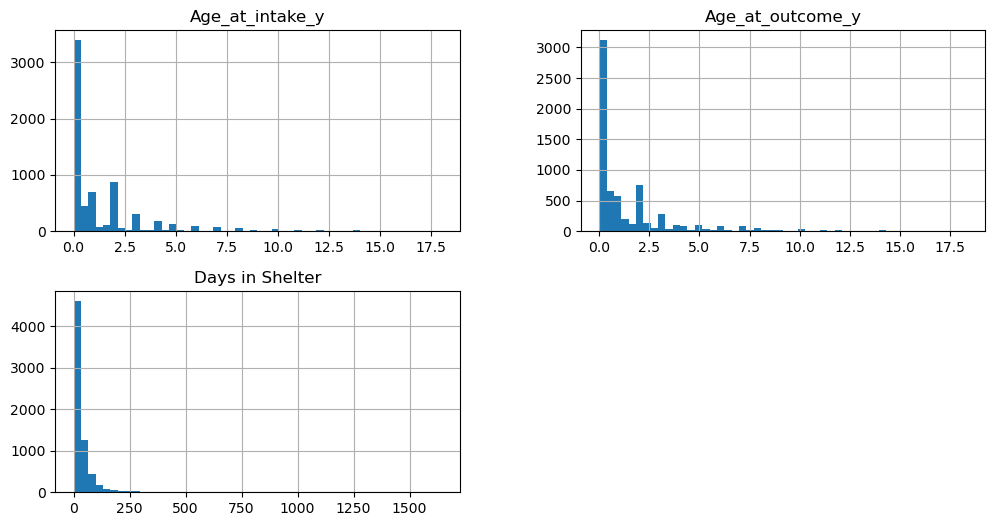

In [224]:
print(nonna_dob[['Age_at_intake_y', 'Age_at_outcome_y', 'Days in Shelter']].skew())
nonna_dob[['Age_at_intake_y', 'Age_at_outcome_y', 'Days in Shelter']].hist(bins=50, figsize=(12,6))

In [225]:
# cap extreme Days in Shelter values at the 99th percentile
cap = nonna_dob['Days in Shelter'].quantile(0.99)
nonna_dob['Days_in_shelter_capped'] = np.where(
    nonna_dob['Days in Shelter'] > cap, cap, nonna_dob['Days in Shelter'])

# log transform Days in Shelter data w/ log1p
nonna_dob['Log_days_in_shelter'] = np.log1p(nonna_dob['Days_in_shelter_capped'])

In [226]:
# sqrt transforms Age values
nonna_dob['Sqrt_age_intake'] = np.sqrt(nonna_dob['Age_at_intake_y'])
nonna_dob['Sqrt_age_outcome'] = np.sqrt(nonna_dob['Age_at_outcome_y'])

array([[<Axes: title={'center': 'Sqrt_age_intake'}>,
        <Axes: title={'center': 'Sqrt_age_outcome'}>],
       [<Axes: title={'center': 'Log_days_in_shelter'}>, <Axes: >]],
      dtype=object)

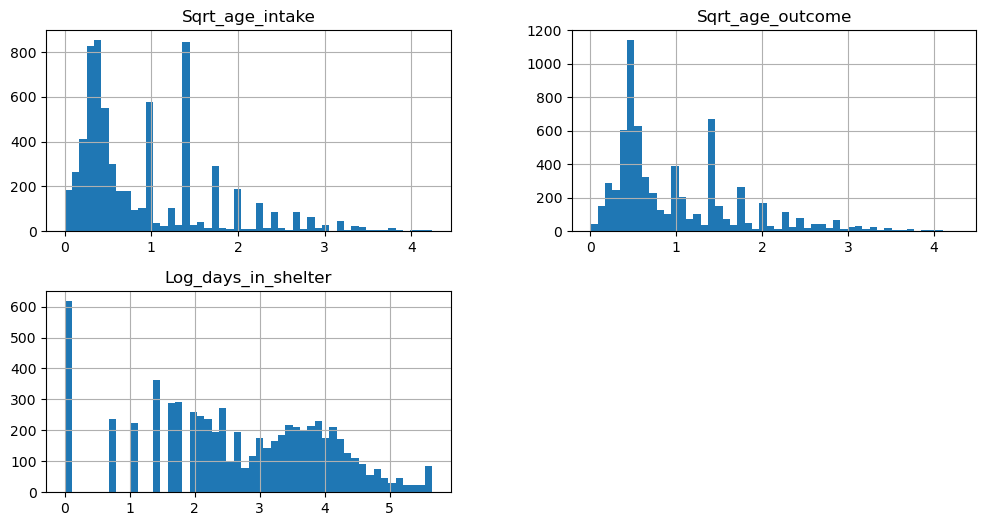

In [227]:
# histogram plots for transformed data
nonna_dob[['Sqrt_age_intake', 'Sqrt_age_outcome', 'Log_days_in_shelter']].hist(bins=50, figsize=(12,6))

#### 2D. Normalization or Standardization

For this project I will be creating different types of models so I have created 2 scaled versions of the numeric variables. 

Standardization (z-score scaling) was applied with regression and classification models in mind, to ensure the features are centered at 0 with unit variance. This standardization will allow later regression and classification models to interpret features consistently. The z-score standardized data will live in a new df, 'nonna_db_std)

Normalization (min-max scaling) was applied for clustering, rescaling values into the [0,1] range so that later clustering models that are based on distance calculations do not get dominated by variables with larger magnitudes. The min-max normalized data will live in a new df, 'nonna_db_norm)

This dual approach provides appropriately scaled inputs for each modeling technique.  For example, the comparison of raw vs. standardized vs. normalized values shows an intake age of 10.35 years was transformed to 3.72 through standardization, indicating it is ~3.72 standard deviations (std.) above the mean. And under normalization, that same intake value of 10.35 years was transformed to 0.575 through normalization, indicating 57% of the maximum age.

In [313]:
# defines numeric cols. for standardization & normalization
numeric_cols = ['Age_at_intake_y', 'Age_at_outcome_y', 'Days_in_shelter_capped']

# creates a StandardScaler object
scaler_std = StandardScaler()
# creates a copy of the nonna_dob df to avoid overwriting existing values
nonna_dob_std = nonna_dob.copy()
# applies z-scoring standardization (each numeric col. is transformed to mean=0, std=1
nonna_dob_std[numeric_cols] = scaler_std.fit_transform(nonna_dob[numeric_cols])

# creates a MinMaxScaler object
scaler_norm = MinMaxScaler()
# creates a copy of the nonna_dob df to avoid overwriting existing values
nonna_dob_norm = nonna_dob.copy()
# applies normalization (each numeric col. is rescaled into [0,1] range
nonna_dob_norm[numeric_cols] = scaler_norm.fit_transform(nonna_dob[numeric_cols])

In [314]:
# comparison of raw v. standardzized v. normalized values
print(nonna_dob[numeric_cols].head()) # prints some raw values
print(nonna_dob_std[numeric_cols].head()) # prints some standardized values
print(nonna_dob_norm[numeric_cols].head()) # prints some normalized values

   Age_at_intake_y  Age_at_outcome_y  Days_in_shelter_capped
0           10.352            10.407                    20.0
1            0.580             0.580                     0.0
2            4.000             4.085                    30.0
3            0.038             0.214                    64.0
4            6.001             6.070                    25.0
   Age_at_intake_y  Age_at_outcome_y  Days_in_shelter_capped
0         3.723902          3.680433               -0.248690
1        -0.375823         -0.411698               -0.675539
2         1.058997          1.047844               -0.035265
3        -0.603213         -0.564107                0.690379
4         1.898493          1.874432               -0.141977
   Age_at_intake_y  Age_at_outcome_y  Days_in_shelter_capped
0         0.575079          0.567510                0.069955
1         0.032220          0.031628                0.000000
2         0.222210          0.222761                0.104932
3         0.002111      

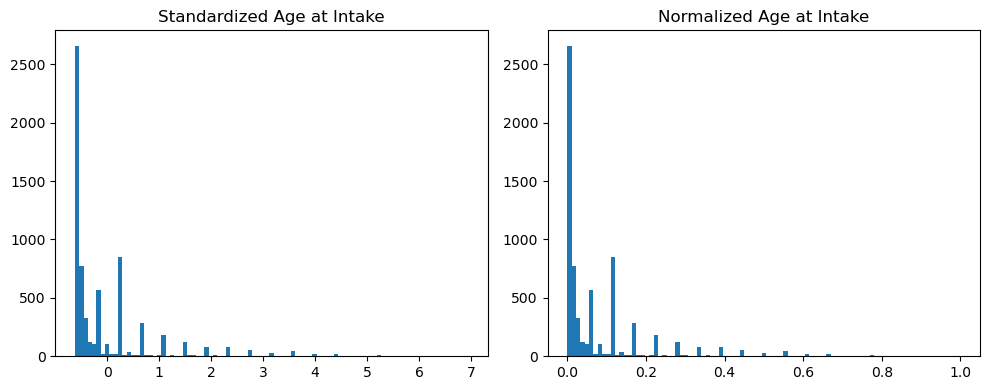

In [315]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist(nonna_dob_std['Age_at_intake_y'], bins='fd')
axs[0].set_title('Standardized Age at Intake')
axs[1].hist(nonna_dob_norm['Age_at_intake_y'], bins='fd')
axs[1].set_title('Normalized Age at Intake')
plt.tight_layout()

## **Exploratory Data Analysis (EDA) Tasks**

### **1. Describe the Variable Characteristics with Summary Statistics**

I prepared a DOB‑cleaned working df (nonna_dob) and generated a variable dictionary and outcome glossary. Numeric variables were summarized with describe() and paired with clear descriptions. Categorical variables were summarized with counts and the modal info. 

In [316]:
# .info() to show all cols in nonna_dob df after creating new cols and transforming
nonna_dob.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6756 entries, 0 to 7224
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Outcome Date            6756 non-null   datetime64[ns]
 1   Animal ID               6756 non-null   int64         
 2   Name                    4011 non-null   object        
 3   Outcome Status          6756 non-null   object        
 4   Euthanasia Reason       344 non-null    object        
 5   Type                    6756 non-null   object        
 6   Sex                     6135 non-null   object        
 7   Spayed/Neutered         5983 non-null   object        
 8   Primary Breed           6748 non-null   object        
 9   Primary Color           6753 non-null   object        
 10  Secondary Color         3584 non-null   object        
 11  Date of Birth           6756 non-null   datetime64[ns]
 12  Intake Date             6756 non-null   datetime64[ns

I generated the following variable dictionary to provide descriptions of each variable in the nonna_dob dataset. This is essentially a reference guide for the reader to understand what each variable captures. 

In [322]:
# dictionary of variable descriptions
variable_descriptions = {
    'Outcome Date': 'Date of recorded final outcome',
    'Animal ID': 'Unique identifier for each animal',
    'Name': "Animal's given name (may be missing)",
    'Outcome Status': 'Final outcome for the animal (mapped to ShelterBuddy definitions)',
    'Euthanasia Reason': 'Reason provided for euthanasia (if applicable)',
    'Type': 'Type of animal species (Dog, Cat, Other)',
    'Sex': "Animal's gender (Male, Female, Unknown)",
    'Spayed/Neutered': 'Sterilization status at intake/outcome',
    'Primary Breed': 'Primary breed description',
    'Primary Color': 'Primary color of the animal',
    'Secondary Color': 'Secondary color of the animal (if applicable)',
    'Date of Birth': 'Recorded date of birth',
    'Intake Date': 'Date the animal entered the shelter',
    'Days in Shelter': 'Total days spent in shelter (raw/uncapped)',
    'Color_grouped': 'Simplified color grouping for analysis',
    'Age_at_intake': 'Age at intake in years (continuous)',
    'Age_at_intake_y': 'Age at intake in years (numeric, standardized variable)',
    'Age_at_outcome_y': 'Age at outcome in years (numeric, standardized variable)',
    'Life_stage_at_intake': 'Life stage category at intake (juvenile, young adult, mature adult, senior)',
    'Sqrt_age_intake': 'Square root transformed age at intake',
    'Sqrt_age_outcome': 'Square root transformed age at outcome',
    'Days_in_shelter_capped': 'Days in shelter capped at 99th percentile',
    'Log_days_in_shelter': 'Log-transformed days in shelter',
    'Sex_encoded': 'Numeric encoding of Sex for modeling (Male = 0, Female = 1, missing encoded as NaN)',
    'SpayedNeutered_encoded': 'Numeric encoding of sterilization status for modeling (not steralized = 0, steralized = 1, missing encoded as NaN)'
}

# builds a df for the variable dictionary
var_df = pd.DataFrame(list(variable_descriptions.items()), columns=['Variable', 'Description'])

# displays variable dictionary df
var_df

,Variable,Description
0,Outcome Date,Date of recorded final outcome
1,Animal ID,Unique identifier for each animal
2,Name,Animal's given name (may be missing)
3,Outcome Status,Final outcome for the animal (mapped to Shelte...
4,Euthanasia Reason,Reason provided for euthanasia (if applicable)
5,Type,"Type of animal species (Dog, Cat, Other)"
6,Sex,"Animal's gender (Male, Female, Unknown)"
7,Spayed/Neutered,Sterilization status at intake/outcome
8,Primary Breed,Primary breed description
9,Primary Color,Primary color of the animal


Here I've created 2 summary tables, one for the numeric columns, and another for the categorical columns. I utilized .describe() to calculate 'count','mean','std','min','25%','50%','75%', and 'max' for each column. Additionally, I've mapped the description from the previous variable dictionary.

The first table below is the numerical summary table, which provides info about the numeric cols. in the dataset. The summary statistics in the table provide insiht into distributional shape and the effect of capping and transformations. The Days in Shelter statistics justify the capping at the 99th percentile and log transformations, as we see the raw 'Days in Shelter' has a mean of approx. 33.65, median of 13, max of 1,641 (uncapped) indicative of high skew. Days_in_shelter_capped reduces the max. from 1,641 to apprx. 285.9 which helps with skewness. Log_days_in_shelter compressed the tail (mean~2.63 and smaller std than raw) and will be used as the target for regression models in later sections of this notebook. While, sqrt_age_intake/outcome used square‑root transforms to reduce skew. 

The second table below is the categorical summary table, which provides info about the categoriccal cols. in the dataset. From the summary statistics, Outcome Status stands out to me due to its dominant most frequent value 'Adopted' at a count of 3572 records. It's important to note because any model predicting outcome would be influemnced by this prevalence. The Spayed/Neutered col. most frequent value, 'Yes' also stands out as a dominant value (4,469). This imbalance is important to note because sterilization status correlated with shelter duration in later tests.

In [323]:
# separates numeric and categorical col.s based on dtypes
numeric_cols = nonna_dob.select_dtypes(include=['int64','int32','float64']).columns
categorical_cols = nonna_dob.select_dtypes(include=['object']).columns

# generates summary stats for num. cols., transposing so vars. are rows
desc_stats = nonna_dob[numeric_cols].describe().T
# adds a description col. by mapping variable names to dictionary
desc_stats['Description'] = desc_stats.index.map(variable_descriptions)
# selects description and .describe() stats for display
numeric_summary = desc_stats[['Description','count','mean','std','min','25%','50%','75%','max']]

# creates new list to hold categorical summaries
cat_summary = []
# loops through each categorical col. 
for col in categorical_cols:
    cat_summary.append({
        'Variable': col, # column name
        'Description': variable_descriptions.get(col, 'No description available'), # description from dict.
        'Unique Values': nonna_dob[col].nunique(), # count of unique values
        # most common value (mode)
        'Most Frequent': nonna_dob[col].mode()[0] if not nonna_dob[col].mode().empty else None, 
        # frequency of most common value in dataset
        'Frequency': nonna_dob[col].value_counts().iloc[0] if not nonna_dob[col].value_counts().empty else None
    })
# converts cat_summary lists to df for a clean display
categorical_summary = pd.DataFrame(cat_summary)

# print heading for numeric column summary
print("Numeric Col. Summary Table:")
# displays numeric_summary table
display(numeric_summary)

# print heading for categorical column summary
print("\nCategorical Col. Summary Table:")
# displays cat_summary table
display(categorical_summary)

Numeric Col. Summary Table:


,Description,count,mean,std,min,25%,50%,75%,max
Animal ID,Unique identifier for each animal,6756.0,11442.296181,3603.284884,5944.0,8096.750000,11430.500000,14560.750000,18239.000000
Days in Shelter,Total days spent in shelter (raw/uncapped),6756.0,33.649941,65.782257,0.0,4.000000,13.000000,41.000000,1641.000000
Age_at_intake_y,"Age at intake in years (numeric, standardized ...",6756.0,1.475802,2.383751,0.0,0.118000,0.337000,2.001000,18.001000
Age_at_outcome_y,"Age at outcome in years (numeric, standardized...",6756.0,1.568668,2.401616,0.0,0.200000,0.444000,2.023000,18.338000
Days_in_shelter_capped,Days in shelter capped at 99th percentile,6756.0,31.652339,46.858421,0.0,4.000000,13.000000,41.000000,285.900000
Log_days_in_shelter,Log-transformed days in shelter,6756.0,2.634707,1.408705,0.0,1.609438,2.639057,3.737670,5.659134
Sqrt_age_intake,Square root transformed age at intake,6756.0,0.931919,0.779370,0.0,0.343511,0.580517,1.414567,4.242759
Sqrt_age_outcome,Square root transformed age at outcome,6756.0,0.999004,0.755475,0.0,0.447214,0.666333,1.422322,4.282289
Sex_encoded,Numeric encoding of Sex for modeling (Male = 0...,6135.0,0.506764,0.499995,0.0,0.000000,1.000000,1.000000,1.000000
SpayedNeutered_encoded,Numeric encoding of sterilization status for m...,5983.0,0.746950,0.434796,0.0,0.000000,1.000000,1.000000,1.000000



Categorical Col. Summary Table:


,Variable,Description,Unique Values,Most Frequent,Frequency
0,Name,Animal's given name (may be missing),2688,Luna,22
1,Outcome Status,Final outcome for the animal (mapped to Shelte...,24,Adopted,3572
2,Euthanasia Reason,Reason provided for euthanasia (if applicable),12,Suffering,129
3,Type,"Type of animal species (Dog, Cat, Other)",3,Cat,4029
4,Sex,"Animal's gender (Male, Female, Unknown)",2,Male,3109
5,Spayed/Neutered,Sterilization status at intake/outcome,2,Yes,4469
6,Primary Breed,Primary breed description,187,Domestic Shorthair,3557
7,Primary Color,Primary color of the animal,89,Black,1495
8,Secondary Color,Secondary color of the animal (if applicable),59,White,2020
9,Color_grouped,Simplified color grouping for analysis,9,Multi-color,4108


This dataset contains 24 unique outcome status, as seen from the .unique() output. I mapped these outcomes to ShelterBuddy's definitions.(ShelterBuddy, n.d.) to create and display an outcome glossary df. This will be a reference for readers to gain an understanding of what the shelter outcomes mean. 

In [319]:
# gets each unique Outcome Status value from the dataset
unique_outcomes = nonna_dob['Outcome Status'].unique()
# displays results
print(unique_outcomes)

['Adopted' 'Transfer Out' 'Adopted Altered' 'Redemption (Offsite)'
 'Reclaimed' 'Adopted Unaltered' 'Unresolved File' 'Euthanized'
 'Unassisted Death' 'DOA' 'Adopted Offsite(Altered)'
 'Adopted Offsite(Unaltered)' 'Unassisted Death - In Foster'
 'Unassisted Death - In Transit' 'Return to Habitat'
 'Cremation - Communal' 'Interred' 'Returned To Owner' 'Euthanasia - RTO'
 'Adopted Offsite' 'DOA - Released to Owner' 'Cremation - Private'
 'Adopted to Finder' 'Escaped']


In [320]:
# map ShelterBuddy definitions to outcome status present in the dataset
outcome_glossary = {
    'Adopted': 'Animal has been adopted.',
    'Adopted Altered': 'Animal adopted after being spayed/neutered.',
    'Adopted Unaltered': 'Animal adopted without being spayed/neutered.',
    'Adopted Offsite': 'Animal adopted at an offsite location.',
    'Adopted Offsite(Altered)': 'Animal adopted offsite after being altered.',
    'Adopted Offsite(Unaltered)': 'Animal adopted offsite without being altered.',
    'Adopted to Finder': 'Animal adopted by the person who found it.',
    'Transfer Out': 'Animal transferred to another agency or rescue group.',
    'Redemption (Offsite)': 'Animal reclaimed by owner at an offsite location.',
    'Reclaimed': 'Animal reclaimed by its owner.',
    'Returned To Owner': 'Animal returned to its owner.',
    'Euthanized': 'Animal euthanized in the shelter.',
    'Euthanasia - RTO': 'Animal euthanized after being returned to owner.',
    'Unassisted Death': 'Animal died without intervention.',
    'Unassisted Death - In Foster': 'Animal died in foster care without intervention.',
    'Unassisted Death - In Transit': 'Animal died during transport without intervention.',
    'DOA': 'Animal arrived dead on arrival.',
    'DOA - Released to Owner': 'Animal arrived dead and was released to owner.',
    'Return to Habitat': 'Animal returned to its natural habitat.',
    'Cremation - Communal': 'Animal cremated communally.',
    'Cremation - Private': 'Animal cremated privately.',
    'Interred': 'Animal buried/interred.',
    'Escaped': 'Animal escaped from shelter custody.',
    'Unresolved File': 'Case file not resolved.'}

# builds a df for clean glossary display
outcome_df = pd.DataFrame({
    'Outcome Status': unique_outcomes,
    'Definition': [outcome_glossary[i] for i in unique_outcomes]
})
# displays outcome glossary df
outcome_df

,Outcome Status,Definition
0,Adopted,Animal has been adopted.
1,Transfer Out,Animal transferred to another agency or rescue...
2,Adopted Altered,Animal adopted after being spayed/neutered.
3,Redemption (Offsite),Animal reclaimed by owner at an offsite location.
4,Reclaimed,Animal reclaimed by its owner.
5,Adopted Unaltered,Animal adopted without being spayed/neutered.
6,Unresolved File,Case file not resolved.
7,Euthanized,Animal euthanized in the shelter.
8,Unassisted Death,Animal died without intervention.
9,DOA,Animal arrived dead on arrival.


### **2. Conduct Univariate Analysis**

#### 2A. Calculate Descriptive Statistics (mean, median, mode, variance, skewness, kurtosis)  of the Key Variables Used in This Project

My key numeric variables are Age_at_intake_y (Age at Intake(yrs.), Days in Shelter, and Age_at_outcome_y (Age at Outcome(yrs.). I identified these specific variables as key because they offer a comprehensive picture of the shelter animal experience, when they enter, how long they stay and their age at outcome. Additionally these are all quantititative columns with variability that makes them ideal for descriptive statistics, visualizations and modeling. For each of these numeric key vars. I've generated and displayed their mean, median, mode, variance, skewness, and kurtosis. The following is a summary of my interpretation of these statistics: 

Days in Shelter has a mean of ~33.65 days, indicating that on average most animals are quite young upon arrival at the shelter. It has a median of 13 days, meaning half of the animals leave the shelter in less than 2 weeks, this tells us that most shelter stays are relatively short. The mode is 0, meaning the most common outcome is a same-day resolution (e.g. immediate return to owner, adoption, etc). The variance of ~4,327.31 inidicates high variability in shelter stays. The skewness metric of ~8.89 shows a strong right skew, which reinforces the earlier insight that most animals leave the shelter quickly, but a few stay for extremely long durations. Lastly, the kurtosis of ~141.06 shows an extremely heavy tail, meaning rare but very long stays (outliers) dominate the distribution. Overall, these descriptive statistics illustrate that shelter stays are short for most animals, but a small number of long-term stay cases heavily influence the average. Which reinforces the need for normalization or standardization for modeling/clustering.

Age at Intake (yrs.) has a mean of ~33.65 days, indicating that on average animals spend about a month in the shelter.  It has a median of ~0.34, meaning that roughly half of the animals are under the age of 4 months old at intake. The mode is ~2, meaning the most common intake age is approximately 2 years old. The variance of ~5.68 inidicates moderate spread of ages. The skewness metric of ~2.87 shows a right skew, which reinforces the earlier insight that most incoming animals are young, but a few are older. Lastly, the kurtosis of ~9.88 shows a heavy tail, meaning a rare few very old animals stretch the distribution. Overall, these descriptive statistics illustrate that the shelter primarily intakes young animals but there are occasional seniors that stretch the distribution. 

Age at Outcome(yrs.) has a mean of ~1.57 years, indicating that on average most animals are still quite young at the time of their final outcome.  It has a median of ~0.44, meaning half of the animals leave the shelter at less than 5 months old. The mode is ~0.05, meaning the most common outcome age is very young, about 2.6 weeks old. The variance of ~5.77 shows a moderate spread of ages, similar to that of Age of Intake(yrs.). The skewness metric of ~2.82 shows a right skew, which reinforces the earlier insight that most animals outcomes involve young animals, though outcomes for some older ones are present. Lastly, the kurtosis of ~9.52 shows a heavy tail, meaning rare but very old animals at outcome are present in the dataset. Overall, these descriptive statistics illustrate that outcomes are concentrated among very young animals, but the shelter also proceses some older aniamals, creating a long-tailed distribution. This reinforces the need for normalization or standardization for modeling/clustering.

In [236]:
# defines key numeric vars. to generate descriptive stats for
key_numvars = ['Days in Shelter', 'Age_at_intake_y', 'Age_at_outcome_y']

# initializes a 'stats' dictionary
stats = {}
# loops through each col. in key_num.vars
for col in key_numvars:
    stats[col] = {
        # generates mean of col.
        'Mean: ': nonna_dob[col].mean(),
        # generates median of col.
        'Median: ': nonna_dob[col].median(),
        # each of these key vars are unimodal, I added iloc[0] to ensure just mode is displayed (not col name and dtype)
        'Mode: ': nonna_dob[col].mode().iloc[0],
        # generates variance of col.
        'Variance: ': nonna_dob[col].var(),
        # generates Skewness of col.
        'Skewness: ': nonna_dob[col].skew(),
        # generates kurtosis of col.
        'Kurtosis: ': nonna_dob[col].kurt()}

# convert dict to df for a nice display
descriptive_stats = pd.DataFrame(stats).T # transpose so vars are rows
# displays descriptive stats df
descriptive_stats

,Mean:,Median:,Mode:,Variance:,Skewness:,Kurtosis:
Days in Shelter,33.649941,13.000,0.000,4327.305272,8.885564,141.060216
Age_at_intake_y,1.475802,0.337,2.001,5.682268,2.865336,9.880669
Age_at_outcome_y,1.568668,0.444,0.057,5.767759,2.815573,9.515522


#### 2B. Create Visualizations of the Key Variables to Examine Distribution or Patterns

I am first creating visualizations for my previously defined key numeric variables,  Age_at_intake_y (Age at Intake(yrs.), Days in Shelter, and Age_at_outcome_y (Age at Outcome(yrs.) from my nonna_dob data. I have plotted histograms with kernal density estimate (KDE) lines to show the overall distribution and skewness for these variables. Upon interpreting these plots, the histograms help to confirm strong right skew for ages and shelter duration, and highlight a small number of extreme long‑stay and older‑age cases. 

To visualize the impact of my previous minmax normalization and z-score standardizations for these numerical values, I also plotted side-by-side histograms(raw, z‑score standardized, and Min‑Max normalized) for each for each key numeric variable (Age_at_intake_y, Days in Shelter, Age_at_outcome_y). From the comparisons, we can see that standardization centers the feature and rescales variance while min‑max rescales to [0,1]. Neither transformation changes distributional shape, outliers and skew remain. A practical takeaway from this comparison is that standardized features (z-scored) should be used for models that assume centered inputs or compare coefficients. Min-max normalized features should be used when using distance metrics (like k-means). 

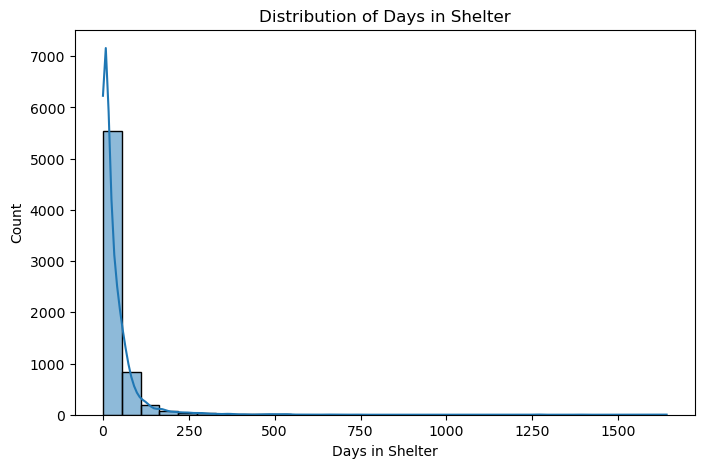

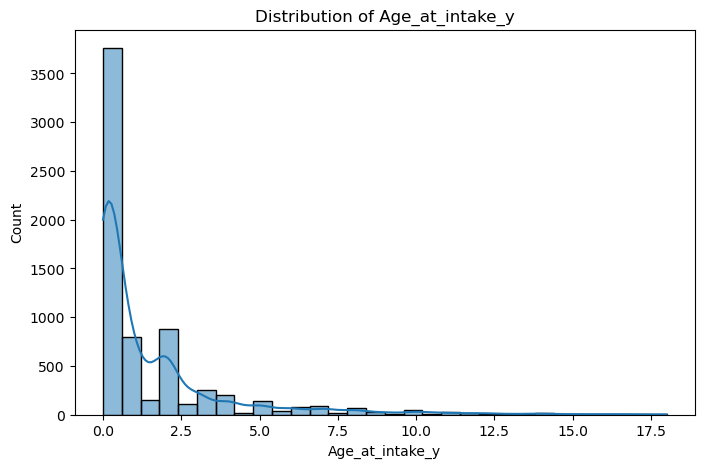

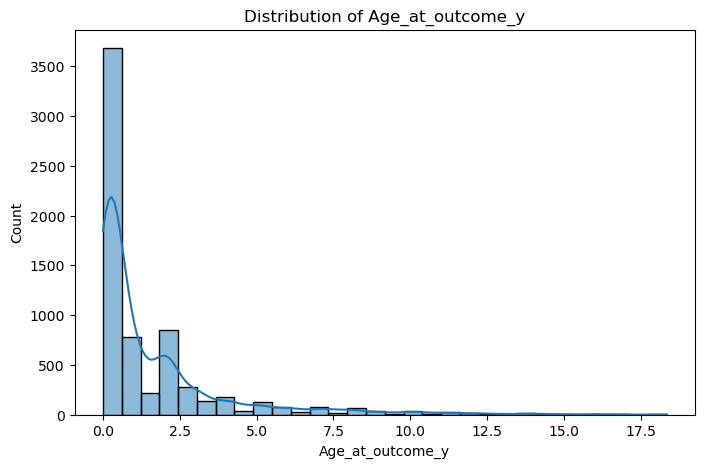

In [237]:
# loops through each key num. col
for col in key_numvars:
    # sets plot size
    plt.figure(figsize = (8,5))
    # creates histogram using 30 bins, with kde line
    sns.histplot(nonna_dob[col], kde = True, bins = 30)
    # sets plot title based on col. name
    plt.title(f"Distribution of {col}")
    # display the histograms
    plt.show()

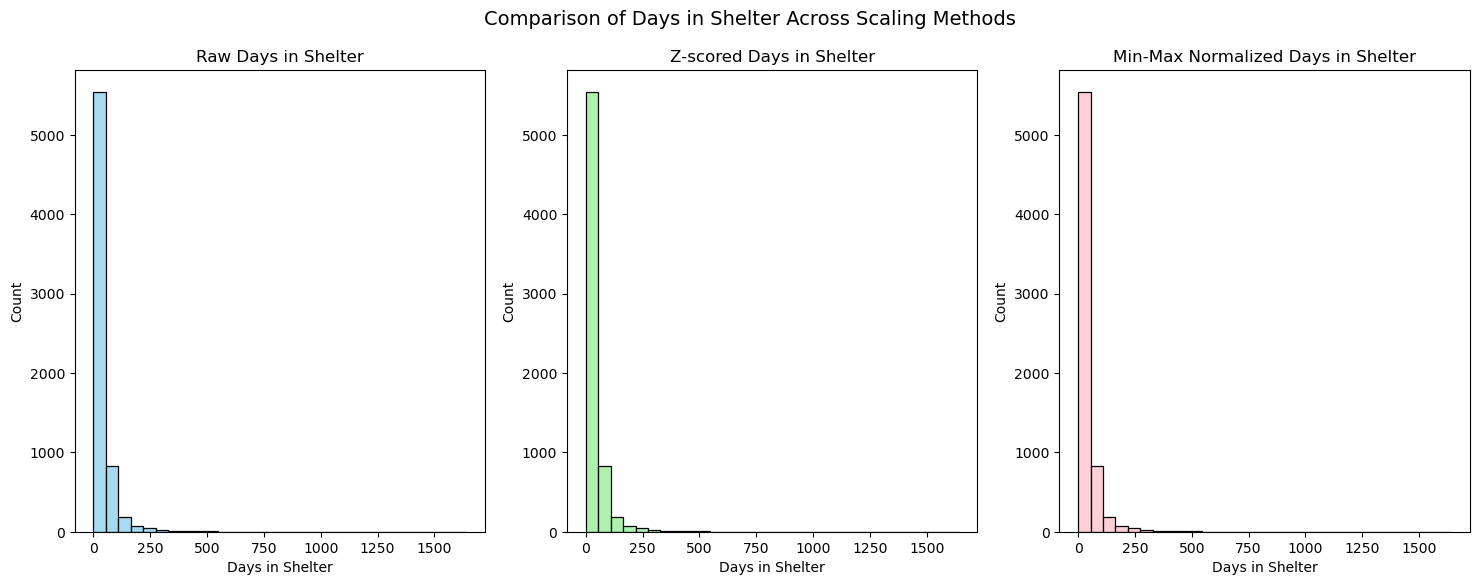

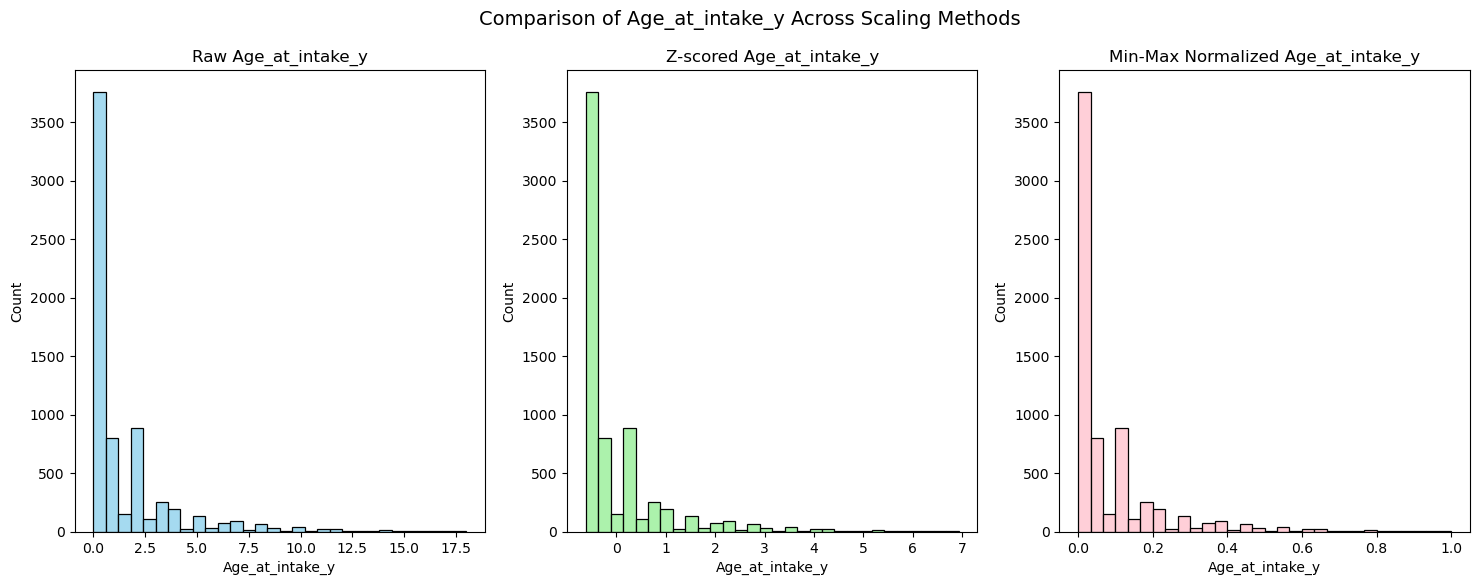

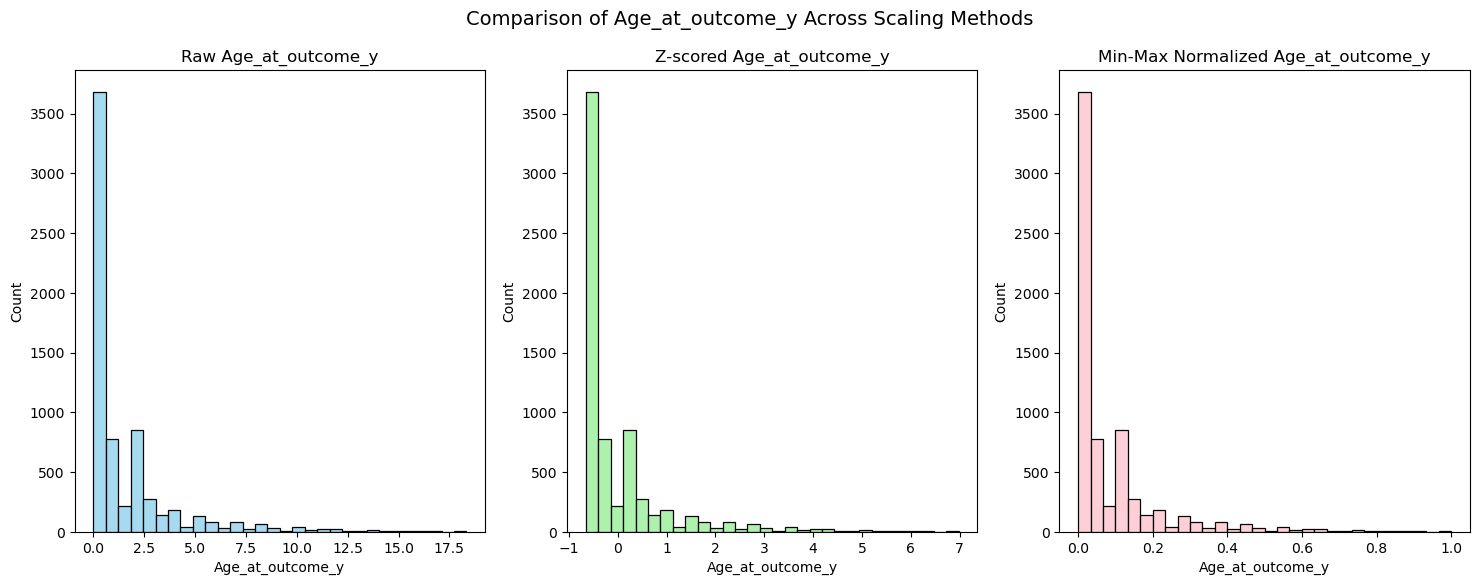

In [254]:
# loops through each key num. col
for col in key_numvars:
    fig, axes = plt.subplots(1, 3, figsize = (18,6))
    # creates hist for raw data
    sns.histplot(nonna_dob[col], bins = 30, ax = axes[0], color = 'skyblue')
    axes[0].set_title(f"Raw {col}")
    # creates hist for Z-scored standardized data
    sns.histplot(nonna_dob_std[col], bins = 30, ax = axes[1], color = 'lightgreen')
    axes[1].set_title(f"Z-scored {col}")
    
    # creates hist for MinMax normalized data
    sns.histplot(nonna_dob_norm[col], bins = 30, ax = axes[2], color = 'pink')
    axes[2].set_title(f"Min-Max Normalized {col}")
    
    plt.suptitle(f"Comparison of {col} Across Scaling Methods", fontsize = 14)
    plt.show()

Next, I created visualizations of key categorical variables, Type, Outcome Status, Sex, Spayed/Neutered, and Color_grouped to show frequency of values within each nonna_dob feature. Each chart is ordered by frequency so the msot common categories appear on top, making class imbalances easily visible. My interpretations of these vizualizations are summarized below:

The 'Frequency of Type' plot highlights that cats are the largest group, dogs are the next largest, and other is a small tail of low count species. 
The 'Frequency of Outcome Status' plot shows the full set of observed outcomes order by frequency. Adopted dominates, with much smaller counts for the remaining categories. 
The 'Frequency of Sex' plot shows that counts are nearly balanced between Male and Female, with maoles having a slightly larger count.
The 'Frequency of Spayed/Neutered' plot clearly displays the large majority of animales are spayed/neutered vs. intact. 
The color_grouped bins reduced 89 raw colros to a usable set of 8 categories. However, multi-color dominance is clearly displayed in the 'Frequency of Color_grouped' plot. 

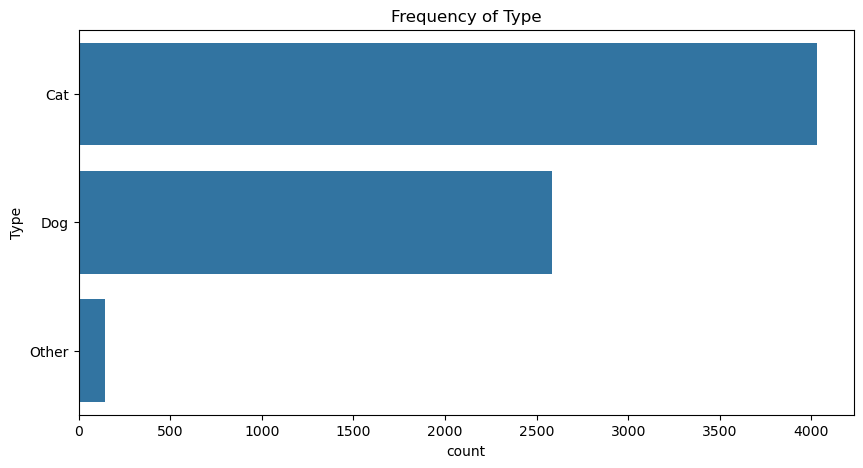

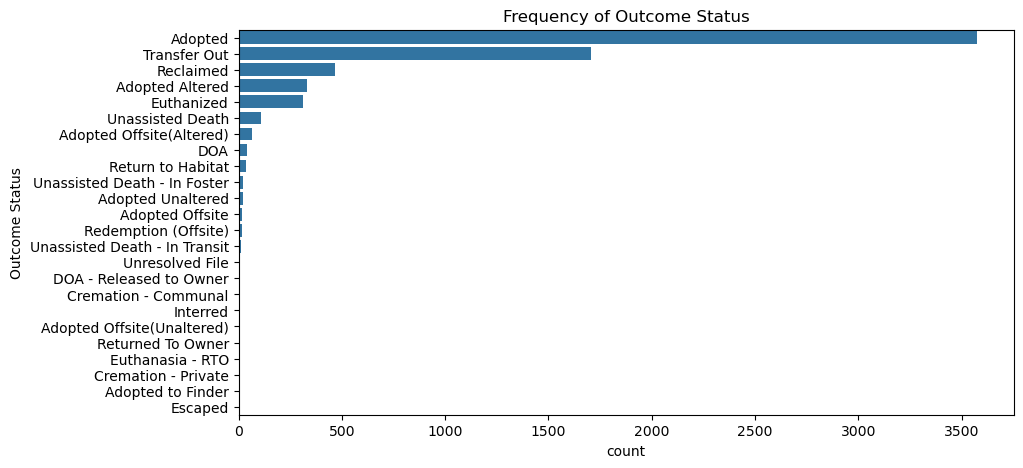

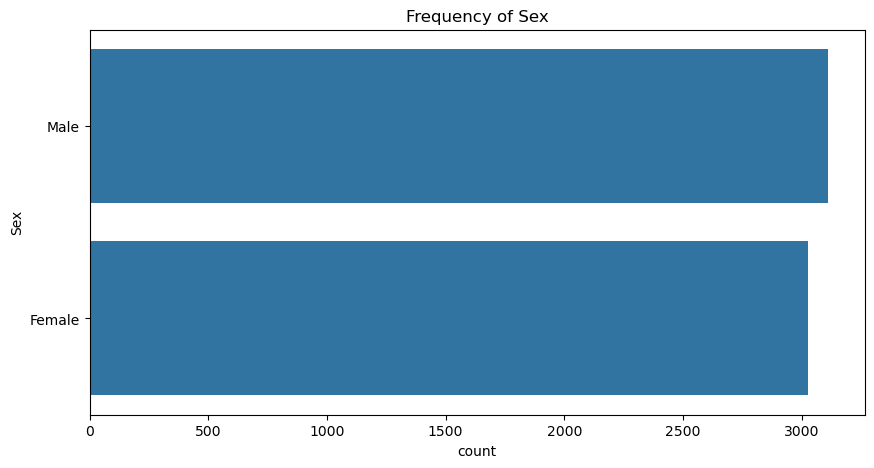

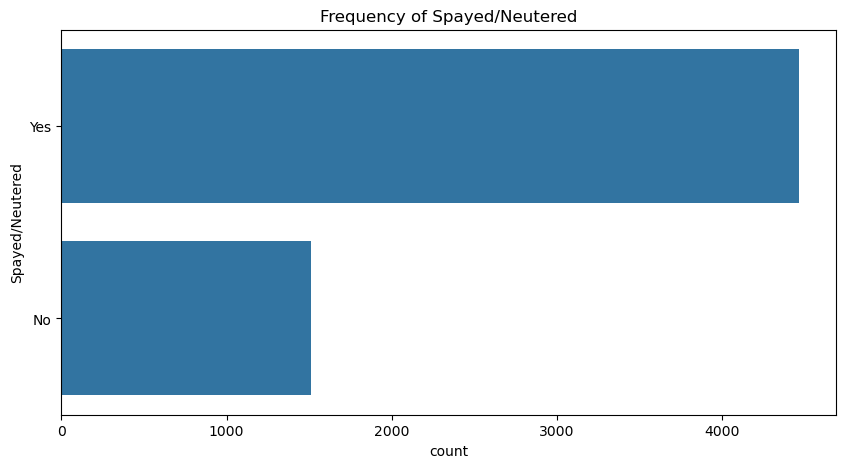

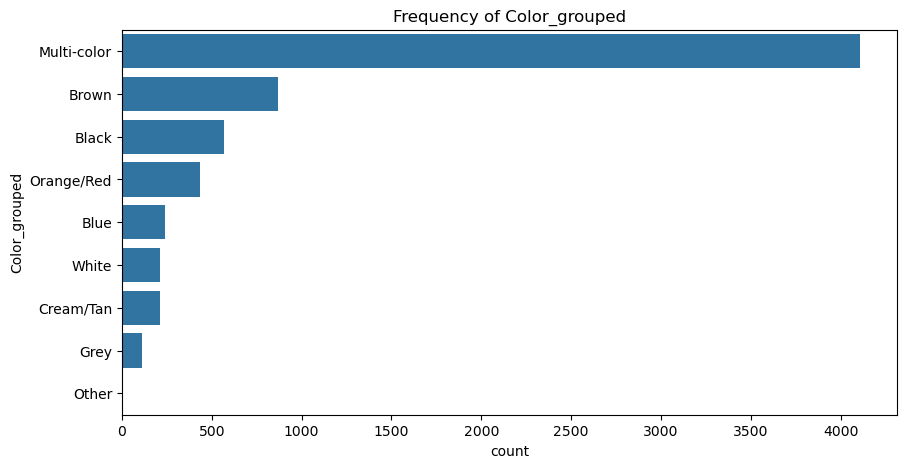

In [324]:
# define key categorical vars. 
cat_vars = ['Type','Outcome Status', 'Sex','Spayed/Neutered', 'Color_grouped']
# loop through cat. vars.
for col in cat_vars:
    # set fig size
    plt.figure(figsize=(10,5))
    # creats plot
    sns.countplot(y=nonna_dob[col], order=nonna_dob[col].value_counts().index)
    # sets plot title based on col. name
    plt.title(f"Frequency of {col}")
    # dispolays plot
    plt.show()

Next, I created a visualization to examine missingness across columns in the dataset. I used a horizontal bar chart to display the count of missing values per column, enhanced with hues from the 'rocket' color palette to emphasize density. In this chart, the darkest bars represent columns with the highest missingness, while lighter hues indicate lower counts.

From the visualization, it's immediately clear that Euthanasia Reason has the highest proportion of missing values at nearly 95%. This aligns with expectations, as this field is only populated when euthanasia is involved in the animal’s outcome, which is relatively rare. Secondary Color follows with 47% missingness, which also makes sense since many animals have only one distinct color. As previously noted, the Name column includes many generic or missing entries, which were treated as missing during preprocessing. It will be interesting to explore whether the absence of a name influences outcome type. Lastly, Spayed/Neutered and Sex show moderate missingness (around 11% and 3%, respectively), which may warrant further investigation depending on their predictive importance.

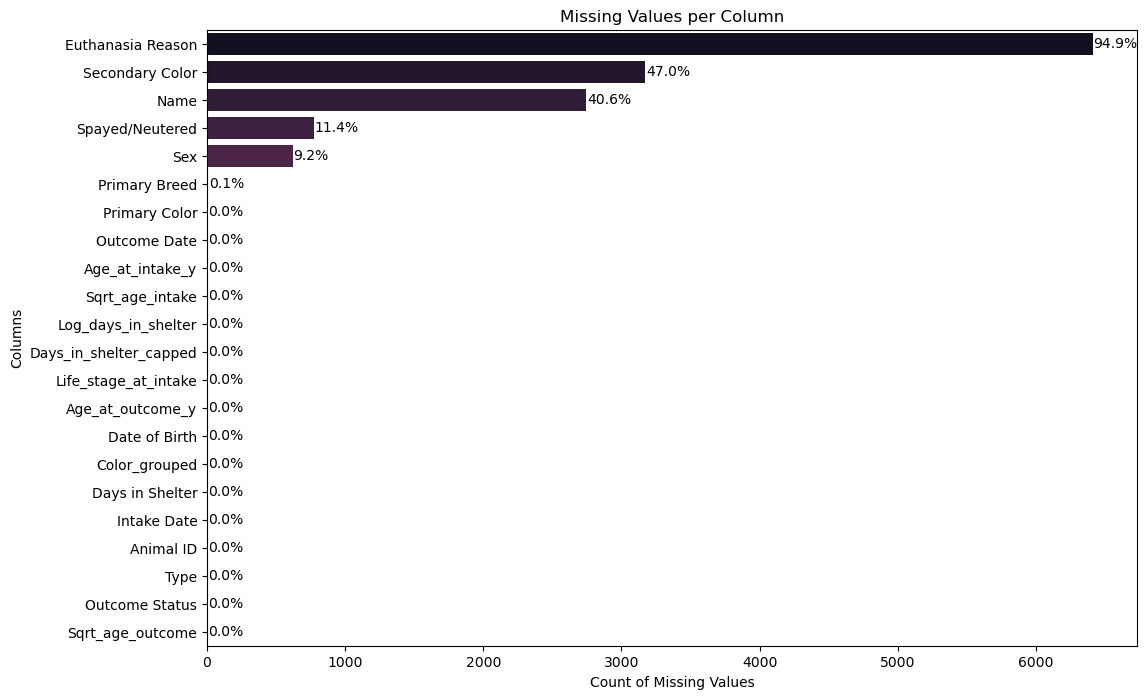

In [249]:
missing_ct = nonna_dob.isnull().sum().sort_values(ascending = False)
# total number of rows for later % missing label calc.
total_rows = len(nonna_dob)

plt.figure(figsize = (12, 8)) # sets figure size
# creates barchart of missingness by column name, indexed by count of missing values, hues align with density of missingess
sns.barplot(x = missing_ct.values, y = missing_ct.index, hue = missing_ct.index, palette = 'rocket')
plt.title("Missing Values per Column") # sets plot title
plt.xlabel("Count of Missing Values") # sets x-axis label
plt.ylabel("Columns") # sets y-axis label
# adds a label indicating % missing for each bar
for i, (count, label) in enumerate(zip(missing_ct.values, missing_ct.index)):
    percent = (count / total_rows) * 100
    plt.text(count + 5, i, f"{percent:.1f}%", va = 'center')
# displays the plot
plt.show()

### **3. Conduct Bivariate Analysis**

#### 3A. Calculate Covariance & Correlation

To begin, I computed Pearson correlations across numeric and numeric‑encoded columns to quantify linear relationships between features. The correlation matrix (displayed below)) highlights expected strong relationships between raw variables and their derived/transformed counterparts. 

From the matrix, strong correlation observations (close to 1) are:
Age_at_intake_y and Age_at_outcome_y (approx.0.997). As expected, outcome age is almost perfectly determined by intake age
Sqrt_age_intake and Sqrt_age_outcome (~0.993). The earlier sqrt transformations preserved the strong relationship between intake and outcome ages. 

Moderate correlations (0.6 - 0.9 range):
Days in Shelter and Days_in_shelter_capped (approx.0.877). The capped version tracks closely with raw shelter days, but trims extreme values. 
Days_in_shelter_capped and log_days_in_shelter (approx. 0.762). The earlier log transformation reduces skewness but maintains a moderate relationship with capped days
Days in Shelter and Log_days_in_shelter (approx. 0.608). Shows how the log compresses the long tail while still reflecting the original variable.

Weak/Negligible correlations: (<0.6)
Animal ID with most variables (e.g., -0.34 with Days in Shelter). As expected, IDs are identifiers, not meaningful predictors.
Age_at_intake_y with Days in Shelter (approx. 0.06) Age at intake does not strongly influence shelter stay duration
The encoded categorical variables (Sex_encoded, SpayedNeutered_encoded) showed generally weak correlations with age variables (all <0.1).
However, SpayedNeutered_encoded had a more positive correlation with Log_days_in_shelter (approx. 0.47) and weaker but noticeable correlations with Days_in_shelter_capped (~0.27) and Days in Shelter (approx. 0.21). This suggests sterilization status may have some association with shelter duration.

Overall, the matrix showed strong relationships between raw variables and their transformations (e.g., Days in Shelter vs. Days_in_shelter_capped). To avoid redundancy and bias, only one representation of each variable will be retained for modeling. For age, Age_at_intake_y was selected, as it is highly correlated with outcome age. For shelter duration, Log_days_in_shelter will be used in regression models to reduce skewness and improve interpretability. Variables such as Animal ID showed negligible correlations and will be excluded from modeling. Encoded categorical predictors (Sex_encoded, SpayedNeutered_encoded) will be retained for hypothesis testing and classification tasks, as they may provide explanatory power even if correlations are modest. Multicollinearity checks will ensure that redundant variables are excluded. This approach balances interpretability with statistical rigor and avoids artificially inflating relationships.

In the following section, 3B, I will create a heatmap to visualize these relationships for easier interpretation.'

In [269]:
# replace -1 (code for missing values) with np.nan so correlation works
nonna_dob['Sex_encoded'] = nonna_dob['Sex_encoded'].replace(-1, np.nan).astype(float)
nonna_dob['SpayedNeutered_encoded'] = nonna_dob['SpayedNeutered_encoded'].replace(-1, np.nan).astype(float)

# ensures numeric_cols is a list to supress errors
numeric_cols = ['Animal ID','Age_at_intake_y', 'Age_at_outcome_y', 'Days_in_shelter_capped',
                'Days in Shelter', 'Log_days_in_shelter', 'Sqrt_age_intake',
                'Sqrt_age_outcome']  

# selects numeric + encoded categorical columns to be used for correlation
num_encodedcols = numeric_cols + ['Sex_encoded', 'SpayedNeutered_encoded']

# Pearson correlation matrix for numeric variables
corr_matrix = nonna_dob[num_encodedcols].corr(method='pearson')

print("Pearson Correlation Matrix:")
print(corr_matrix)

Pearson Correlation Matrix:
                        Animal ID  Age_at_intake_y  Age_at_outcome_y  \
Animal ID                1.000000         0.014377         -0.011402   
Age_at_intake_y          0.014377         1.000000          0.997200   
Age_at_outcome_y        -0.011402         0.997200          1.000000   
Days_in_shelter_capped  -0.417576         0.055290          0.120563   
Days in Shelter         -0.343291         0.061426          0.135886   
Log_days_in_shelter     -0.362667        -0.038359          0.007439   
Sqrt_age_intake          0.032363         0.943022          0.942469   
Sqrt_age_outcome        -0.011413         0.943404          0.949528   
Sex_encoded             -0.017900         0.023680          0.024659   
SpayedNeutered_encoded  -0.151351         0.067087          0.082578   

                        Days_in_shelter_capped  Days in Shelter  \
Animal ID                            -0.417576        -0.343291   
Age_at_intake_y                       0.05529

To complement the correlation analysis, I calculated the covariance matrix for numeric and encoded categorical variables. Unlike correlation, which standardizes values between –1 and 1, covariance reflects the raw co‑movement between variables and is influenced by their scale

The covariance matrix confirms the same structural relationships seen in the prevous correlation matrix but highlights the impact of scale. Shelter duration variables covary strongly with each other, while age variables covary positively in both raw and transformed forms. Encoded categorical variables show modest covariance with shelter duration, suggesting potential explanatory value. To avoid redundancy and scale bias, only one representation of each variable will be retained for modeling, with Log_days_in_shelter preferred for regression tasks and Age_at_intake_y selected for age.

In [270]:
# creates covariance matrix of numeric and encoded cat. cols.
cov_matrix = nonna_dob[num_encodedcols].cov()
# adds a title for the matrix
print("Covariance Matrix:")
# display covariance matrix
print(cov_matrix)

Covariance Matrix:
                           Animal ID  Age_at_intake_y  Age_at_outcome_y  \
Animal ID               1.298366e+07       123.487021        -98.666752   
Age_at_intake_y         1.234870e+02         5.682268          5.708825   
Age_at_outcome_y       -9.866675e+01         5.708825          5.767759   
Days_in_shelter_capped -7.050524e+04         6.175842         13.567710   
Days in Shelter        -8.137110e+04         9.632063         21.467770   
Log_days_in_shelter    -1.840886e+03        -0.128809          0.025167   
Sqrt_age_intake         9.088561e+01         1.751969          1.764065   
Sqrt_age_outcome       -3.106712e+01         1.698943          1.722788   
Sex_encoded            -3.233520e+01         0.028828          0.030241   
SpayedNeutered_encoded -2.380098e+02         0.070031          0.086907   

                        Days_in_shelter_capped  Days in Shelter  \
Animal ID                        -70505.238420    -81371.098524   
Age_at_intake_y      

#### 3B. Create Visualization

To aid in the interpretation of my Pearson Correlation Matrix, I've created the below heatmap to illustrate the relationships between my numeric variables. I also created a supplemental scatterplot to help visually confirm the relationship between Age_at_intake_y'and 'Age_at_outcome_y

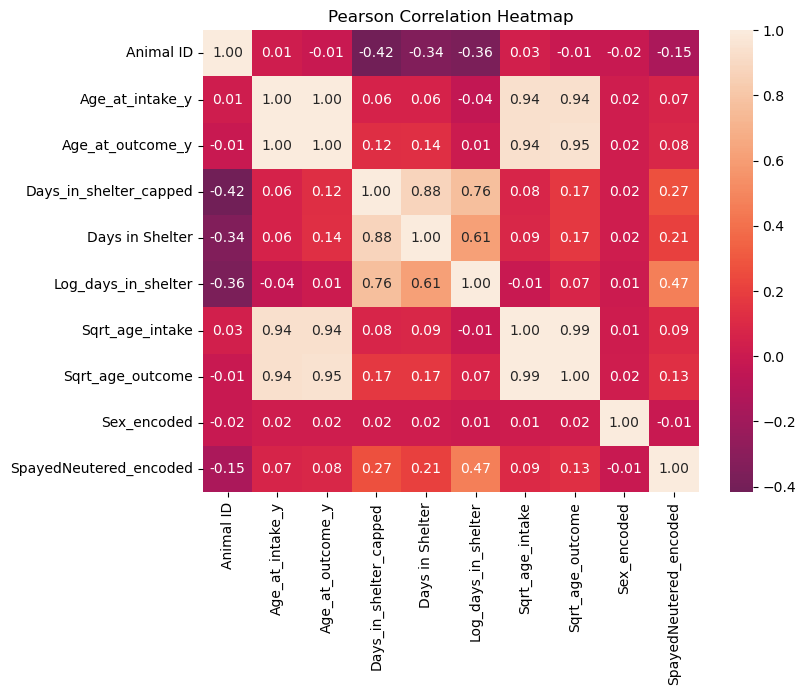

In [275]:
# sets figure size
plt.figure(figsize = (8,6))
# creates heatmap of corr matrix using 'rocket' color palette and 2 dec. place formatting
sns.heatmap(corr_matrix, annot = True, cmap = 'rocket', center = 0, fmt = ".2f")
# sets heatmap title
plt.title("Pearson Correlation Heatmap")
# displays heatmap
plt.show()

I wanted to get a better look at the relationship between Age at Intake and Age at Outcome so I created the scatterplot below. The scatterplot shows a very strong, near‑linear relationship: intake age almost entirely predicts outcome age (consistent with the Pearson correlation ≈ 0.997). This makes sense since Age at Outcome is derived by calculating the age at outcome date (from Date of Birth col.). 

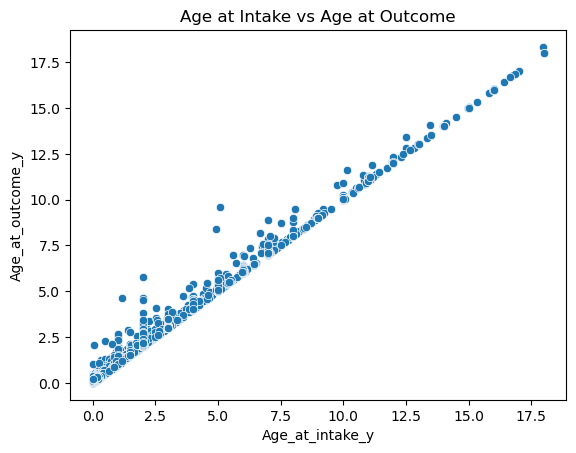

In [273]:
# creates a scatter plot of Age_at_intake_y'and 'Age_at_outcome_y
sns.scatterplot(x='Age_at_intake_y', y='Age_at_outcome_y', data = nonna_dob)
# sets plot title
plt.title("Age at Intake vs Age at Outcome")
# displays the scatter plot
plt.show()

To further explore the relationships between categorical and numeric variables, I calculated the Spearman rank correlation using the encoded versions of Sex and Spayed/Neutered alongside the numeric features. Unlike Pearson, Spearman correlation is based on ranked values and is better suited for categorical encodings.

The Spearman correlation matrix confirms the strong relationships between age variables and between shelter duration measures, while highlighting that sterilization status (SpayedNeutered_encoded) has a moderate association with shelter duration. Sex (Sex_encoded) shows no meaningful relationship. These findings complement the Pearson and covariance analyses by providing additional insight into categorical predictors. For modeling, redundant variables will be excluded, while sterilization status will be retained as a categorical predictor due to its potential explanatory power.

A supplmental heatmap was created as a visual aid for this Spearman correlation matrix to aid interpretation. 

Spearman Correlation Matrix:
                        Animal ID  Age_at_intake_y  Age_at_outcome_y  \
Animal ID                1.000000         0.057059         -0.026906   
Age_at_intake_y          0.057059         1.000000          0.958348   
Age_at_outcome_y        -0.026906         0.958348          1.000000   
Days_in_shelter_capped  -0.387484        -0.010868          0.168869   
Days in Shelter         -0.387485        -0.010870          0.168880   
Log_days_in_shelter     -0.387484        -0.010868          0.168869   
Sqrt_age_intake          0.057059         1.000000          0.958348   
Sqrt_age_outcome        -0.026906         0.958348          1.000000   
Sex_encoded             -0.018441        -0.005438          0.001044   
SpayedNeutered_encoded  -0.158907         0.161155          0.232479   

                        Days_in_shelter_capped  Days in Shelter  \
Animal ID                            -0.387484        -0.387485   
Age_at_intake_y                      -0.0108

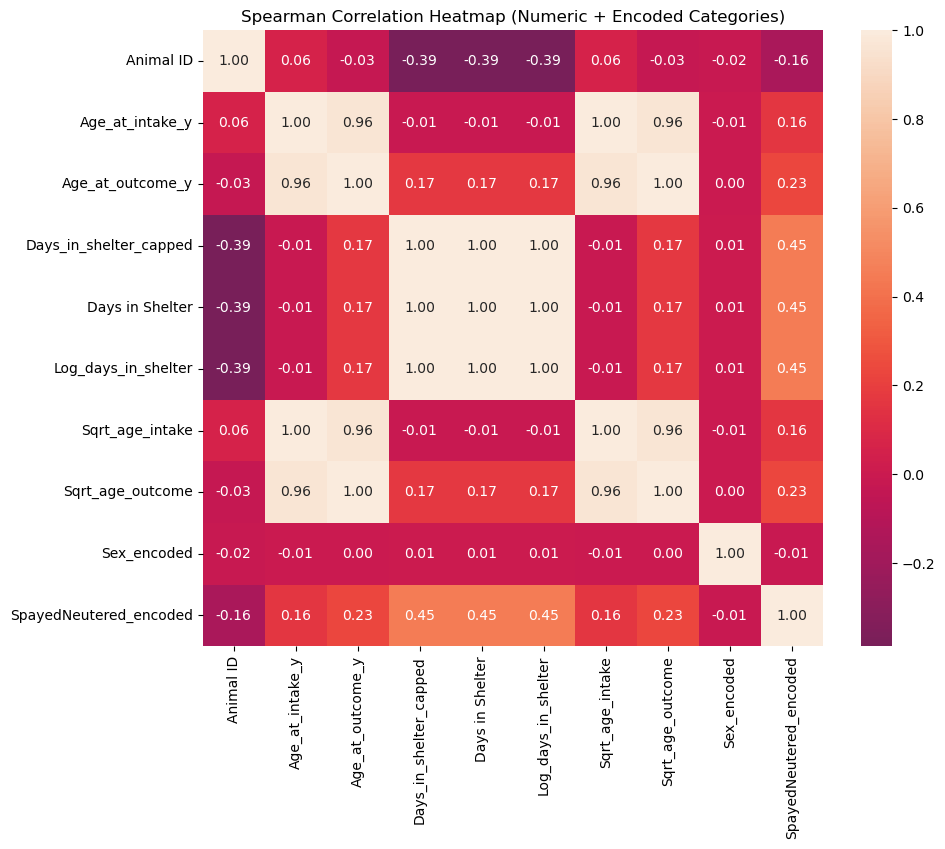

In [276]:
# runs Spearman correlation matrix on numeric and encoded vars. 
spearman_corr = nonna_dob[num_encodedcols].corr(method='spearman')

# prints a descriptive heading above the matrix
print("Spearman Correlation Matrix:")
# displays spearman correlation matrix
print(spearman_corr)

# heatmap of spearman corr. matrix for visualization
plt.figure(figsize=(10,8))
sns.heatmap(spearman_corr, annot=True, cmap='rocket', center=0, fmt=".2f")
# adds plot title
plt.title("Spearman Correlation Heatmap (Numeric + Encoded Categories)")
# displays heatmap
plt.show()

### **4. Test Statistics**

#### 4A. Develop a Hypothesis & Select Appropriate Test Statistics (Based on the Data)

Hypothesis:
H0 (Null hypothesis): There is no difference in average shelter stay durations between spayed/neutered and intact (non-spayed/neutered) animals. 
H1 (alternative): Spayed/neutered animals have a different average shelter duration than intact animals.

I used Welch’s two‑sample t‑test to compare mean shelter duration between spayed/neutered and intact animals because the groups are independent and variances may differ. Welch’s t‑test reports a t‑statistic and a p‑value, here I used alpha =  0.05 to decide significance. 

In [325]:
# defines spayed group, where Spayed/Neutered == 'Yes', NAs are droppped
spayed_group = nonna_dob.loc[nonna_dob['Spayed/Neutered'] == 'Yes', 'Log_days_in_shelter'].dropna()
# defines intact group, where Spayed/Neutered == 'No', NAs are droppped
intact_group = nonna_dob.loc[nonna_dob['Spayed/Neutered'] == 'No', 'Log_days_in_shelter'].dropna()

# checks assumption of equal variances with Levene's test
levene_stat, levene_p = stats.levene(spayed_group, intact_group)
# print results
print("Levene’s test for equal variances:")
print(f"Statistic = {levene_stat:.4f}, p-value = {levene_p:.4f}")


Levene’s test for equal variances:
Statistic = 14.6522, p-value = 0.0001


In [326]:
# computes Welch's t-test comparing shelter duration for spayed v. intact animals
t_stat, p_val = stats.ttest_ind(spayed_group, intact_group, equal_var = False)

# print a heading
print("Welch’s t-test (unequal variances)")
# print tsest statistic and p-value
print(f"t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

# displays reject/fail to reject H0 depending on significance (alpha = 0.05 significance level) 
if p_val < 0.05:
    print("Result: Reject H0, Shelter duration differs significantly between spayed/neutered and intact animals.")
else:
    print("Result: Fail to reject H0, No significant difference in shelter duration between groups.")

Welch’s t-test (unequal variances)
t-statistic = 39.1511, p-value = 0.0000
Result: Reject H0, Shelter duration differs significantly between spayed/neutered and intact animals.


#### 4B. For each test (e.g., t-test, F-test, Chi-squared), discuss the assumptions and whether they hold for the dataset. 

T-test Assumptions:
Independence of observations: Each animal represents a unique case, so independence holds.
Normality of the dependent variable: Shelter stay duration is skewed, but the log transformation (Log_days_in_shelter) was used to approximate normality.
Homogeneity of variance: Levene’s test indicated unequal variances (p = 0.0001). Therefore, Welch’s t‑test was applied, which does not assume equal variances.
Overall, the assumptions were reasonably addressed, with adjustments made to ensure validity.

#### 4C. Explain Test Statistic Results, Interpret p-values & Draw Conclusion

Welch’s t‑test statistic: 39.15

p‑value: < 0.0001

Since p < 0.05, the null hypothesis is rejected. This indicates a statistically significant difference in average shelter duration between spayed/neutered and intact animals. Sterilization status is strongly associated with shelter stay length. Spayed/neutered animals have significantly different average durations compared to intact animals. This finding aligns with earlier correlation results, where SpayedNeutered_encoded showed moderate associations with shelter duration variables. Together, these results suggest sterilization status is an important predictor and should be retained in subsequent modeling and hypothesis testing.

###  **5. Regression & Classification**

### 5A. Regression Analysis

For this regression analysis task I will be developing a multiple Regression model. This model was chosen because the dependent variable is continuous and the predictors include both numeric and categorical encodings. The targetvariable(y) is Shelter duration, specifically log_days_in_shelter to handle skewness. My predictors are both numeric, Age at intake (Age_at_intake_y), and encoded categorical vars, sex (Sex_encoded), and sterilization status (SpayedNeutered_encoded). These selections will allow me to quantify how intake age, sex, and sterilization status influence shelter stay length.

I am utilizing the stats package sm.OLS() to create the regression model. The resulting model summary provides insights about the model performance. The summary showed a R-squared of 0.226 and an adjusted R-squared of 0.225, indicating approximately 22.6% of the variance in shelter stay duration is explained by the selected predictors. While not extremely high, this indicates that sterilization status and intake age provide meaningful explanatory power. The overall regression model is statistically significant (F = 572.4, p < 0.001). And the number of obversvations at 5,893 is a prettty large sample size that supports the robustness of the results.

Next, I'll interpret the results of the model. The baseline log shelter duration when all predictors are 0, is 1.73 (const./intercept). Intake age is negatively associated with shelter duration, Age_at_intake_y(coef = –0.0488, p < 0.001). Older animals tend to have slightly shorter stays, holding other factors constant. Additionally, Sex is not a statistically significant predictor of shelter duration, Sex_encoded(coef = 0.0222, p = 0.477). Finally, Sterilization status is strongly associated with shelter duration, SpayedNeutered_encoded(coef = 1.4932, p < 0.001). Spayed/neutered animals have significantly longer stays on average, consistent with earlier correlation and t‑test findings

The required assumptions for a multiple Regression model are independance, normality of residuals, homeoscedasticity, and multicolinearity. Each animal is a unique case, so the independance assumption holds. In terms of normality, the log transformation reduced skewness, and residual diagnostics (Omnibus and Jarque‑Bera tests) suggest mild deviations but acceptable fit. For homoscedacity, the Durbin‑Watson statistic (~1.95) indicates no major autocorrelation issues. Finally, the Condition number (9.20) is low, suggesting predictors are not highly collinear.

In [287]:
# keeps only rows w/ complete data for regression
data = nonna_dob[['Age_at_intake_y', 'Sex_encoded', 'SpayedNeutered_encoded', 'Log_days_in_shelter']].dropna()

# defines predictors (X)
X = data[['Age_at_intake_y', 'Sex_encoded', 'SpayedNeutered_encoded']]
# defines target (y)
y = data['Log_days_in_shelter']

# adds an intercept (constant) col. to the predictors so the model fits an intercept term
X = sm.add_constant(X)
# fit Ordinary Least Squares (OLS) linear regression of y on x
model = sm.OLS(y, X).fit()
# displays model summary
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Log_days_in_shelter   R-squared:                       0.226
Model:                             OLS   Adj. R-squared:                  0.225
Method:                  Least Squares   F-statistic:                     572.4
Date:                 Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                         17:08:48   Log-Likelihood:                -9407.2
No. Observations:                 5893   AIC:                         1.882e+04
Df Residuals:                     5889   BIC:                         1.885e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const             

### 5B. Classification Model

For this classification task I will be developing a Logistic Regression model using SpayedNeutered_encoded (binary, 1 = spayed/neutered, 0 = intact) as the target and - Age_at_intake_y, Log_days_in_shelter, Sex_encoded as my predictors. Logistic regression is appropriate for binary classification and provides interpretable coefficients so that I can show how the predictors influence the probability of sterilization status. 

I then evaluated the model using multiple performance metrics to determine the following:
The model performs very well for spayed/neutered animals (Class 1), with high recall (0.96) and strong F1 (0.90). This means it rarely misses spayed/neutered cases.
Performance is weaker for intact animals (Class 0), with recall only 0.42. The model struggles to correctly identify intact animals, often misclassifying them as spayed/neutered.
Overall accuracy (0.83) and weighted F1 (0.81) indicate the model is reliable, but the imbalance between classes suggests it is biased toward predicting spayed/neutered status.
This imbalance likely reflects the dataset itself, where spayed/neutered animals are more common (support = 1348 vs. 420).

I've included a confusion matrix and ROC curve plot to help with visual interpretation of the model's performance. The confusion matrix supports that the model demonstrates strong predictive ability for sterilization status, particularly for spayed/neutered animals. However, its lower recall for intact animals highlights class imbalance as a limitation. And the ROC curve further supports the model's effectiveness with an Area Under the Curve (AUC) of 0.82. This indicates that the model is able to distinguish between spayed/neutered and intact animals significantly better than random guessing. While the model favors predicting spayed/neutered status, the ROC curve shows that its overall sensitivity and specificity trade‑off is well balanced.

These results establish a baseline classification model, which will be compared against machine learning approaches in Section 6B to assess whether more advanced methods can improve performance across both classes.

In [327]:
# defines predictors (X)
X = data[['Age_at_intake_y', 'Log_days_in_shelter', 'Sex_encoded']]
# defines target (y)
y = data['SpayedNeutered_encoded']

# splits the data into training and test sets
# allocating 30% for test set. random_state = 42 fixes random seed for reproducibiltiy  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# trains logistic regression model
log_reg = LogisticRegression(max_iter=1000)
# fits the model on the training data
log_reg.fit(X_train, y_train)

# generates class predictions on the test set
y_pred = log_reg.predict(X_test)
# generates class predicted probabilities for the positive class for ROC/AUC
y_prob = log_reg.predict_proba(X_test)[:,1]

Accuracy: 0.832579185520362

Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.42      0.55       420
         1.0       0.84      0.96      0.90      1348

    accuracy                           0.83      1768
   macro avg       0.80      0.69      0.72      1768
weighted avg       0.82      0.83      0.81      1768

ROC-AUC: 0.8159433728981207


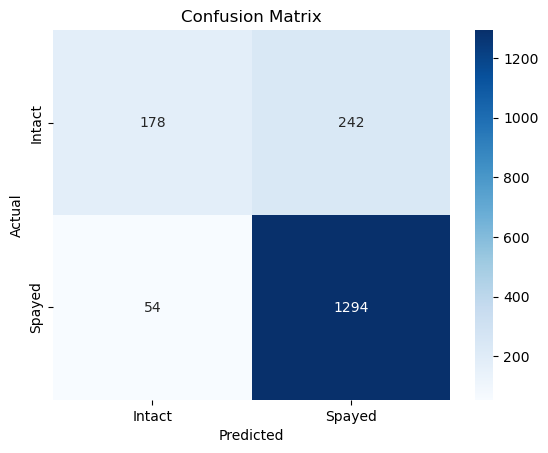

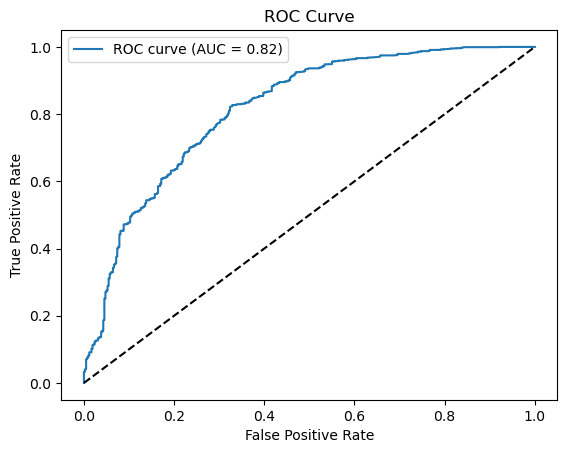

In [328]:
# prints model accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))
# displays the classification report 
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# computes and displays ROC-AUC (area under ROC curve) using predicted probabilities
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# computes confusion matrix (rows = actual, cols. = predicted)
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix as heatmap
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["Intact","Spayed"], yticklabels = ["Intact","Spayed"])
# adds plot title
plt.title("Confusion Matrix")
# adds x-axis label
plt.xlabel("Predicted")
# adds y-axis label
plt.ylabel("Actual")
# displays confusion matrix heatmap
plt.show()

# computes ROC curve points (false positive rate, true pos. rate)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# plots roc curve
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0,1],[0,1],'k--')
# adds x-axis label
plt.xlabel("False Positive Rate")
# adds y-axis label
plt.ylabel("True Positive Rate")
# adds plot title
plt.title("ROC Curve")
# adds plot legend
plt.legend()
# display the plot
plt.show()

###  **6. Advanced Analysis Techniques**

### 6A. Clustering Analysis

K‑Means clustering was applied to uncover natural groupings in the dataset using intake age (Age_at_intake_y), shelter duration (Log_days_in_shelter), and sex (Sex_encoded). These features were standardized to ensure equal weighting, and dimensionality reduction via Principal Component Analysis (PCA) was used to visualize the clusters in two dimensions.

The resulting clusters showed moderate separation, with a silhouette score of 0.41, indicating that the data points fit reasonably well within their assigned clusters. The PCA plot revealed two distinct groupings, though some overlap was present. This suggests that while the selected features do capture some structure in the data, the separation is not sharply defined.

These clusters were formed without using the sterilization status label, offering an unsupervised perspective on how animals group based on intake characteristics. This complements the supervised classification models used in earlier sections and provides insight into underlying patterns that may influence shelter outcomes.

In [304]:
# prep data for clustering analyses
features = ['Age_at_intake_y', 'Log_days_in_shelter', 'Sex_encoded'] # defines features
cluster_data = nonna_dob[features].dropna() # drops NAs

# standardizing the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# applies K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

C:\Users\lahop\Bellevue\dsc530\envs\book_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.41


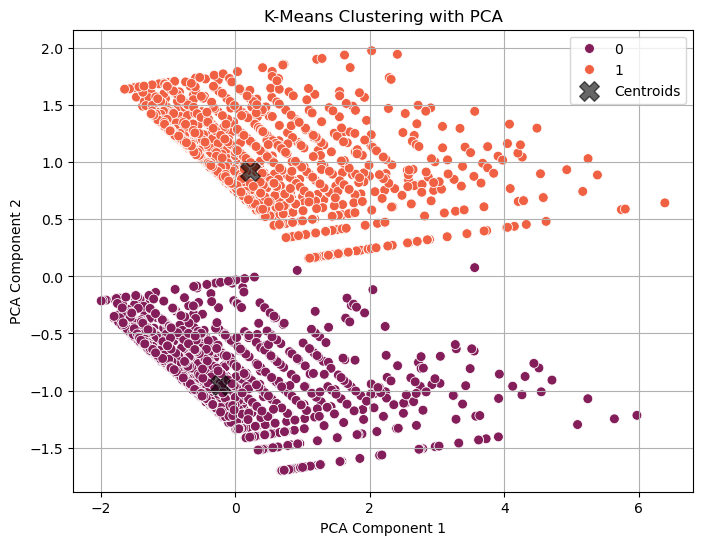

In [305]:
# evaluates clustering quality
sil_score = silhouette_score(scaled_data, cluster_labels) # gets silhoutte score
# displays silhoutte score
print(f"Silhouette Score: {sil_score:.2f}")

# applies PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# creates viz. that plots clusters in PCA space
plt.figure(figsize = (8,6)) # set fig size.
# creates scatter plot
sns.scatterplot(x = pca_data[:,0], y = pca_data[:,1], hue = cluster_labels, palette = 'rocket', s = 50)
# adds centroids to viz.
centroids = pca.transform(kmeans.cluster_centers_)
# centroid viz. formatting
plt.scatter(centroids[:,0], centroids[:,1], c = 'black', s = 200, alpha = 0.6, marker = 'X', label = 'Centroids')
# sets plot title
plt.title("K-Means Clustering with PCA")
# sets x-axis label
plt.xlabel("PCA Component 1")
# sets y-axis label
plt.ylabel("PCA Component 2")
# adds a legend
plt.legend()
# adds gridlines for readability
plt.grid(True)
# displays the viz.
plt.show()

### 6B. Machine Learning Approach to Regression or Classification

I trained a linear regression model to predict log‑transformed shelter duration (Log_days_in_shelter) from intake age (Age_at_intake_y), sex (Sex_encoded), and sterilization status (SpayedNeutered_encoded). The model was trained on 75% of the data and evaluated on a held‑out 25% test set (train_test_split with random_state=42), so the reported performance is out‑of‑sample.
Summary of model performance (test set):
- R² ~ 0.23, meaning the three predictors explain about 23% of the variance in Log_days_in_shelter on the test set.
- RMSE ~ 1.18 (on the log scale), which describes the average prediction error in log‑days.
Additionally, the coefficients indicate older intake age is associated with shorter stays (~ −0.051, approx. 5% decrease per year), sex has a minimal effect (~ 0.035 approx, 3–4% increase), and spayed/neutered status is associated with substantially longer stays (~ 1.48 -> exp(1.48) ~ 4.4x expected days). These results show sterilization status is an important predictor but not proof of causation. To improve this model I would recommend to report exponentiated coefficients and confidence intervals, run diagnostics, and consider adding covariates or more flexible models to improve predictive performance.

In [306]:
# defines predictors and target
X = data[['Age_at_intake_y', 'Sex_encoded', 'SpayedNeutered_encoded']]
y = data['Log_days_in_shelter']

# sets train/test split (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# instantiates the linear regression model
lin_reg = LinearRegression()
# fits the model on the training set 
lin_reg.fit(X_train, y_train)

# out of sample predictions
y_pred = lin_reg.predict(X_test)

In [308]:
# evaluation metrics
r2 = r2_score(y_test, y_pred) # r2 score
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE

# displays evaluaton metrics
print("R²:", r2)
print("RMSE:", rmse)
print("Intercept:", lin_reg.intercept_)
print("Coefficients:", lin_reg.coef_)

R²: 0.22991666142786638
RMSE: 1.181227678093193
Intercept: 1.7282849904330433
Coefficients: [-0.05132907  0.03491503  1.48227451]
